## 0. Initial set up

###  0.1 Imports

In [1]:
# Imports

import pandas as pd
import numpy as np
import dask 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import folium 
import graphviz, toolz, cloudpickle
import matplotlib
from matplotlib import rcParams
import xgboost as xgb
import pandas_profiling
import scipy

from  pprint import pprint
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
import time
import datetime as dt

In [3]:
import matplotlib.dates as dates
import matplotlib.ticker as ticker

In [4]:
import os
os.chdir("../")

In [5]:
%matplotlib inline

### 0.2 Error functions

In [6]:
def MAPE (test, predicted):
    return np.mean(np.abs(test-predicted)/ test)

def RMSE (test, predicted):
    return np.sqrt(np.mean((test-predicted)**2))

## 1. EDA 

Goal of this section is to combine and merge the data into a cohesive file 

###  1.1 Stations data

#### 1.1.1 Merging the data into one df

In [8]:
!dir data

2014  2015  2016  2017


In [9]:
#Load the individual files and mark the year 

stations_2014= pd.read_csv("./data/2014/Stations_2014.csv")
stations_2015= pd.read_csv("./data/2015/Stations_2015.csv")
stations_2016= pd.read_csv("./data/2016/Stations_2016.csv")
stations_2017= pd.read_csv("./data/2017/Stations_2017.csv")

stations_2014["Year"] = 2014
stations_2015["Year"] = 2015
stations_2016["Year"] = 2016
stations_2017["Year"] = 2017

In [10]:
stations_2015.columns

Index(['code', 'name', 'latitude', 'longitude', 'Year'], dtype='object')

In [11]:
# Revew shapes of the stations of each year 

print("2014: ", stations_2014.shape, ", 2015: ", stations_2015.shape, "2016: ", stations_2016.shape, 
     "2017: ", stations_2017.shape)

2014:  (459, 5) , 2015:  (460, 5) 2016:  (465, 5) 2017:  (546, 5)


In [12]:
# Merge all the dataframes into a station master

stations_master = pd.merge(stations_2014, stations_2015, how = "outer", on = ['code', 'name', 'latitude', 'longitude'], 
                          suffixes = ('_2014','_2015'))
stations_master = pd.merge(stations_master, stations_2016, how = "outer", on = ['code', 'name', 'latitude', 'longitude'])
stations_master = pd.merge(stations_master, stations_2017, how = "outer", on = ['code', 'name', 'latitude', 'longitude'],
                          suffixes = ('_2016', '_2017'))

In [13]:
unmatched_stations = stations_master[stations_master.isna().sum(axis=1)>0].sort_values(by=["latitude", "longitude"])
matched_stations = stations_master[stations_master.isna().sum(axis=1)==0].sort_values(by=["latitude", "longitude"])
unmatched_stations.head(30)

code                                   name   latitude  longitude  \
465  7015                    LaSalle / 4e avenue  45.430740 -73.591911   
466  6715         Natatorium (LaSalle / Rolland)  45.444408 -73.575568   
449  6715         Natatorium (LaSalle / Rolland)  45.444433 -73.575788   
467  7048                        Métro Angrignon  45.446534 -73.603541   
468  7056                     Godin / Bannantyne  45.447554 -73.577263   
469  7051                        Jogues / Allard  45.449901 -73.600251   
470  6706                     Beatty / de Verdun  45.450730 -73.572575   
343  6706                        Beatty / Verdun  45.450837 -73.572446   
471  7059                    Argyle / Bannantyne  45.453246 -73.576815   
419  6309                     5e avenue / Verdun  45.456049 -73.571877   
472  6309                  5e avenue / de Verdun  45.456049 -73.571877   
441  6707                        Drake / de Sève  45.456351 -73.582292   
473  6707      Métro Jolicoeur (Drake / de Sève)  45.456498 -73.582144   
464  6754                           Eadie/Dubois  45.457597 -73.590529   
474  6754                         Eadie / Dubois  45.457597 -73.590529   
475  7057                 2e avenue / Wellington  45.457894 -73.567528   
476  7010                   Belmore / Sherbrooke  45.459233 -73.637405   
477  6426  Métro Verdun (Willibrord / de Verdun)  45.459488 -73.572092   
436  6428     Berlioz / Boul de l'Ile des Soeurs  45.459593 -73.544377   
331  6426                    Willibrord / Verdun  45.459707 -73.571438   
478  6428          Berlioz / de l'Île des Soeurs  45.459986 -73.543956   
479  7058                    Gordon / Wellington  45.461078 -73.567307   
453  6742                        Briand / Carron  45.462362 -73.596650   
480  6742                      Briand / le Caron  45.462362 -73.596650   
481  7060                de l'Église / de Verdun  45.463001 -73.571569   
482  6379               de l'Église / Bannantyne  45.463254 -73.575879   
332  6379               Bannantyne / de l'Église  45.463257 -73.575621   
483  7013                 Benny Crescent / Benny  45.464315 -73.625570   
484  6115                    Benny / de Monkland  45.466914 -73.631704   
335  6115                       Benny / Monkland  45.466965 -73.631664   

     Year_2014  Year_2015  Year_2016  Year_2017  
465        NaN        NaN        NaN     2017.0  
466        NaN        NaN        NaN     2017.0  
449     2014.0     2015.0     2016.0        NaN  
467        NaN        NaN        NaN     2017.0  
468        NaN        NaN        NaN     2017.0  
469        NaN        NaN        NaN     2017.0  
470        NaN        NaN        NaN     2017.0  
343     2014.0     2015.0     2016.0        NaN  
471        NaN        NaN        NaN     2017.0  
419     2014.0     2015.0     2016.0        NaN  
472        NaN        NaN        NaN     2017.0  
441     2014.0     2015.0     2016.0        NaN  
473        NaN        NaN        NaN     2017.0  
464        NaN        NaN     2016.0        NaN  
474        NaN        NaN        NaN     2017.0  
475        NaN        NaN        NaN     2017.0  
476        NaN        NaN        NaN     2017.0  
477        NaN        NaN        NaN     2017.0  
436     2014.0     2015.0     2016.0        NaN  
331     2014.0     2015.0     2016.0        NaN  
478        NaN        NaN        NaN     2017.0  
479        NaN        NaN        NaN     2017.0  
453     2014.0     2015.0     2016.0        NaN  
480        NaN        NaN        NaN     2017.0  
481        NaN        NaN        NaN     2017.0  
482        NaN        NaN        NaN     2017.0  
332     2014.0     2015.0     2016.0        NaN  
483        NaN        NaN        NaN     2017.0  
484        NaN        NaN        NaN     2017.0  
335     2014.0     2015.0     2016.0        NaN

In [14]:
print( stations_master.shape)
print( unmatched_stations.shape)
print( matched_stations.shape)

(775, 8)
(540, 8)
(235, 8)


In [15]:
# no. of same stations with different name or code:
unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = False).sum()

94

In [16]:
unmatched_stations[unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = False)]

code                                       name   latitude  longitude  \
419  6309                         5e avenue / Verdun  45.456049 -73.571877   
472  6309                      5e avenue / de Verdun  45.456049 -73.571877   
464  6754                               Eadie/Dubois  45.457597 -73.590529   
474  6754                             Eadie / Dubois  45.457597 -73.590529   
453  6742                            Briand / Carron  45.462362 -73.596650   
..    ...                                        ...        ...        ...   
746  6737        Jacques-Casault / Christophe-Colomb  45.552123 -73.630103   
418  6701                           Marseille / Viau  45.563921 -73.548912   
766  6701                        de Marseille / Viau  45.563921 -73.548912   
289  6721                      Cadillac / Sherbrooke  45.577136 -73.546289   
772  6721  Métro Cadillac (Sherbrooke / de Cadillac)  45.577136 -73.546289   

     Year_2014  Year_2015  Year_2016  Year_2017  
419     2014.0     2015.0     2016.0        NaN  
472        NaN        NaN        NaN     2017.0  
464        NaN        NaN     2016.0        NaN  
474        NaN        NaN        NaN     2017.0  
453     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...  
746        NaN        NaN        NaN     2017.0  
418     2014.0     2015.0     2016.0        NaN  
766        NaN        NaN        NaN     2017.0  
289     2014.0     2015.0     2016.0        NaN  
772        NaN        NaN        NaN     2017.0  

[94 rows x 8 columns]

The above 47 stations simply have different names, and represent the exact same
location (from a lat-long perspective). So we will drop the older versions and keep the new versions

In [17]:
unique_unmatched_stations = unmatched_stations[~(unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = "last"))] 
unique_unmatched_stations.sort_values(by='code')

code                                 name   latitude  longitude  \
284  5002             St-Charles / Châteauguay  45.533200 -73.515600   
663  5002             St-Charles / Montarville  45.533703 -73.515283   
647  5003                      Place Longueuil  45.529512 -73.517691   
357  5003                      Place Longueuil  45.529400 -73.517800   
322  5005            St-Charles / St-Sylvestre  45.536408 -73.512776   
..    ...                                  ...        ...        ...   
628  7077               Fullum / Jean Langlois  45.526128 -73.546002   
667  7078                 Hochelaga / Chapleau  45.534453 -73.559652   
533  7079                  Gauvin / Notre-Dame  45.500043 -73.560412   
546  7080  President-Kennedy / Robert Bourassa  45.504407 -73.572543   
515  7081             Lincoln / Lambert Closse  45.491384 -73.586013   

     Year_2014  Year_2015  Year_2016  Year_2017  
284     2014.0     2015.0     2016.0        NaN  
663        NaN        NaN        NaN     2017.0  
647        NaN        NaN        NaN     2017.0  
357     2014.0     2015.0     2016.0        NaN  
322     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...  
628        NaN        NaN        NaN     2017.0  
667        NaN        NaN        NaN     2017.0  
533        NaN        NaN        NaN     2017.0  
546        NaN        NaN        NaN     2017.0  
515        NaN        NaN        NaN     2017.0  

[493 rows x 8 columns]

In [18]:
# Even though the code is the same, the location and/ or name have changed in 2017 in some cases. 

#HOw many of the 493 have the same code? 

unique_unmatched_stations[unique_unmatched_stations.duplicated(subset=["code"], keep=False)].sort_values(by='code')

code                           name   latitude  longitude  Year_2014  \
284  5002       St-Charles / Châteauguay  45.533200 -73.515600     2014.0   
663  5002       St-Charles / Montarville  45.533703 -73.515283        NaN   
357  5003                Place Longueuil  45.529400 -73.517800     2014.0   
647  5003                Place Longueuil  45.529512 -73.517691        NaN   
322  5005      St-Charles / St-Sylvestre  45.536408 -73.512776     2014.0   
..    ...                            ...        ...        ...        ...   
749  6925      Louis-Hébert / Jean-Talon  45.553139 -73.602711        NaN   
416  6929         St-André / St-Grégoire  45.531330 -73.591550     2014.0   
653  6929         St-André / St-Grégoire  45.531412 -73.591749        NaN   
461  6930            Paul Boutet / Jarry  45.559178 -73.614130        NaN   
763  6930  Paul Boutet / des Regrattiers  45.559842 -73.615447        NaN   

     Year_2015  Year_2016  Year_2017  
284     2015.0     2016.0        NaN  
663        NaN        NaN     2017.0  
357     2015.0     2016.0        NaN  
647        NaN        NaN     2017.0  
322     2015.0     2016.0        NaN  
..         ...        ...        ...  
749        NaN        NaN     2017.0  
416     2015.0     2016.0        NaN  
653        NaN        NaN     2017.0  
461        NaN     2016.0        NaN  
763        NaN        NaN     2017.0  

[364 rows x 8 columns]

In [19]:
# For the sake of simplicity, in these 182 stations, we will assume the 2017 name and lat-long, 
# we are assuming (perhaps, safely) that the lat-long difference is quite small 

unmatched_stations_codes = unique_unmatched_stations[~unique_unmatched_stations.sort_values(by='code')\
                                                     .duplicated(subset=['code'], keep = 'last')]

unmatched_stations_codes.sort_values(by='code')

<ipython-input-19-1e054f537fa0>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unmatched_stations_codes = unique_unmatched_stations[~unique_unmatched_stations.sort_values(by='code')\


code                                            name   latitude  \
663  5002                        St-Charles / Montarville  45.533703   
357  5003                                 Place Longueuil  45.529400   
678  5005                       St-Charles / St-Sylvestre  45.536378   
559  6001  Hôtel-de-Ville 2 (du Champs-de-Mars / Gosford)  45.509328   
253  6002                          Ste-Catherine / Dézéry  45.539230   
..    ...                                             ...        ...   
628  7077                          Fullum / Jean Langlois  45.526128   
667  7078                            Hochelaga / Chapleau  45.534453   
533  7079                             Gauvin / Notre-Dame  45.500043   
546  7080             President-Kennedy / Robert Bourassa  45.504407   
515  7081                        Lincoln / Lambert Closse  45.491384   

     longitude  Year_2014  Year_2015  Year_2016  Year_2017  
663 -73.515283        NaN        NaN        NaN     2017.0  
357 -73.517800     2014.0     2015.0     2016.0        NaN  
678 -73.512642        NaN        NaN        NaN     2017.0  
559 -73.554347        NaN        NaN        NaN     2017.0  
253 -73.541082     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...        ...  
628 -73.546002        NaN        NaN        NaN     2017.0  
667 -73.559652        NaN        NaN        NaN     2017.0  
533 -73.560412        NaN        NaN        NaN     2017.0  
546 -73.572543        NaN        NaN        NaN     2017.0  
515 -73.586013        NaN        NaN        NaN     2017.0  

[311 rows x 8 columns]

In [20]:
# They all look like new additions from 2017? 
unmatched_stations_codes.isna().sum()

code           0
name           0
latitude       0
longitude      0
Year_2014    217
Year_2015    216
Year_2016    214
Year_2017     96
dtype: int64

In [39]:
#Some 96 stations were only present during 2014- 2016. Versus ~217 stations were pretty much created in 2017. 

unmatched_stations_codes[unmatched_stations_codes["Year_2017"].isna()]
#We try to look for any special information regarding the locations that were disabled in 2017

code                             name   latitude  longitude  Year_2014  \
343  6706                  Beatty / Verdun  45.450837 -73.572446     2014.0   
441  6707                  Drake / de Sève  45.456351 -73.582292     2014.0   
331  6426              Willibrord / Verdun  45.459707 -73.571438     2014.0   
335  6115                 Benny / Monkland  45.466965 -73.631664     2014.0   
338  6363          Côte St-Antoine / Royal  45.468800 -73.619800     2014.0   
..    ...                              ...        ...        ...        ...   
307  6033            16e avenue / Beaubien  45.558481 -73.583304     2014.0   
66   6395       Pierre-de-Coubertin / Aird  45.558960 -73.548687     2014.0   
270  6735  François-Perrault / L.-O.-David  45.561396 -73.601544     2014.0   
463  6753          St-Zotique / 39e avenue  45.573471 -73.574975        NaN   
423  6722    Bossuet / Pierre-de-Coubertin  45.573733 -73.539446     2014.0   

     Year_2015  Year_2016  Year_2017  category  
343     2015.0     2016.0        NaN       0.5  
441     2015.0     2016.0        NaN       0.5  
331     2015.0     2016.0        NaN       0.5  
335     2015.0     2016.0        NaN       0.5  
338     2015.0     2016.0        NaN       0.5  
..         ...        ...        ...       ...  
307     2015.0     2016.0        NaN       0.5  
66      2015.0     2016.0        NaN       0.5  
270     2015.0     2016.0        NaN       0.5  
463        NaN     2016.0        NaN       1.0  
423     2015.0     2016.0        NaN       0.5  

[96 rows x 9 columns]

#### Check the two stations for which our prediction is most concerned

In [22]:
unmatched_stations_codes[unmatched_stations_codes['code'].isin([6184,6015])]

Empty DataFrame
Columns: [code, name, latitude, longitude, Year_2014, Year_2015, Year_2016, Year_2017]
Index: []

In [23]:
prio_points= matched_stations[matched_stations['code'].isin([6184,6015])]
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

In [24]:
unmatched_stations_codes.columns

Index(['code', 'name', 'latitude', 'longitude', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017'],
      dtype='object')

In [25]:
# The two main locations have been consistent through the years. 

#2014-2016 change in stations has been minimal and can be ignored for the purposes of this exercise. 
# the 2017 piece cannot be ignored as it is somewhat significant. It is illustrative to understand the extent 
# of these changes in a graphical way. 

def categorizer(s):
    if s.iloc[0:3].isna().sum()==3:
        return 0 #2017 only 
    elif np.isnan(s.iloc[3]) and s.iloc[0:3].isna().sum()==0:
        return 0.5 #decommissioned in 2017
    else:
        return 1  #Other

unmatched_stations_codes["category"] = (unmatched_stations_codes[['Year_2014', 'Year_2015',
       'Year_2016','Year_2017']].apply(categorizer,axis = 1))

<ipython-input-25-f94437f86588>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_stations_codes["category"] = (unmatched_stations_codes[['Year_2014', 'Year_2015',


In [26]:
unmatched_stations_codes.category.value_counts()

0.0    214
0.5     94
1.0      3
Name: category, dtype: int64

In [27]:
unmatched_stations_codes.shape

(311, 9)

In [28]:
unmatched_stations_codes[unmatched_stations_codes.category==1]

code                     name   latitude  longitude  Year_2014  \
462  6752     Hutchison / Beaubien  45.526246 -73.613747        NaN   
460  6311      Drolet / St-Zotique  45.534795 -73.609546        NaN   
463  6753  St-Zotique / 39e avenue  45.573471 -73.574975        NaN   

     Year_2015  Year_2016  Year_2017  category  
462        NaN     2016.0     2017.0       1.0  
460     2015.0     2016.0        NaN       1.0  
463        NaN     2016.0        NaN       1.0

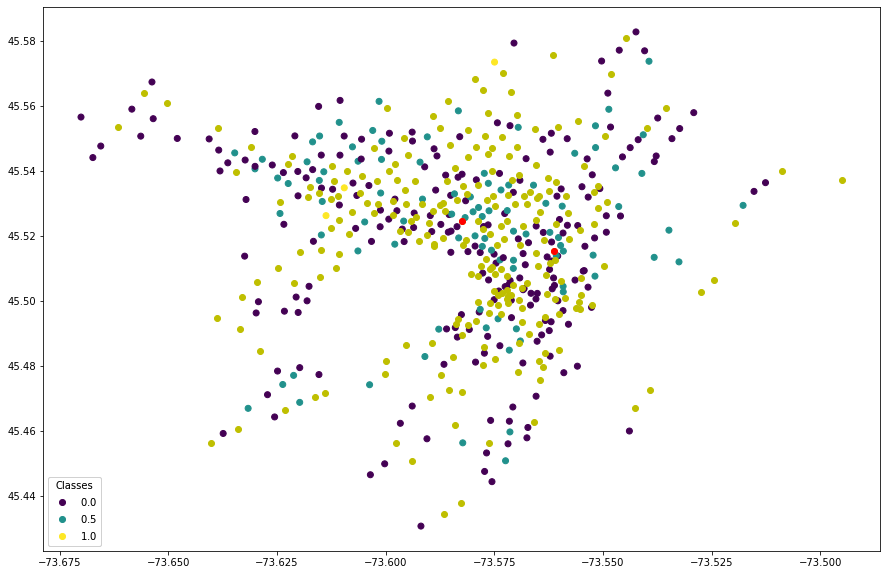

In [29]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()

scatter = ax.scatter(unmatched_stations_codes["longitude"], unmatched_stations_codes['latitude'], 
           c= unmatched_stations_codes['category'])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
#purple dots representing the newly added stations in 2017
#blue dots representing removed stations


ax.scatter(matched_stations['longitude'], matched_stations['latitude'], c='y')
#gray dots representing the unchanged stations 

ax.scatter(prio_points['longitude'], prio_points['latitude'], c='r') 
#red dots representing the concerned origin and destination

ax.add_artist(legend1)

In [30]:
## Unfortunately, the red-dots seem to be have been surrounded by some stations that were clearly replaced in
# 2017 by other stations that were further away from the red-dot

#Hence, we should consider the adjusted demand when making our prediction

stations_df = pd.concat([unmatched_stations_codes, matched_stations])

#### Clean up the stations_df dataframe

In [31]:
stations_df.loc[stations_df.category.isna(),"category"] = "Fully Matched"

In [32]:
stations_df.category.value_counts()

#stations_df is the one source of truth on DataFrames

Fully Matched    235
0.0              214
0.5               94
1.0                3
Name: category, dtype: int64

In [33]:
stations_df = stations_df.replace({'category':{0:'Added in 2017', 0.5: 'Decommissioned in 2017',
                                 1:'Other'
                                }})

In [34]:
stations_df.code.is_unique

True

In [35]:
stations_df = stations_df.set_index('code')

In [36]:
stations_df

name   latitude  longitude  \
code                                                                            
7015                                LaSalle / 4e avenue  45.430740 -73.591911   
6715                     Natatorium (LaSalle / Rolland)  45.444408 -73.575568   
7048                                    Métro Angrignon  45.446534 -73.603541   
7056                                 Godin / Bannantyne  45.447554 -73.577263   
7051                                    Jogues / Allard  45.449901 -73.600251   
...                                                 ...        ...        ...   
6713                            30e avenue / St-Zotique  45.568225 -73.579436   
6702                         Chauveau / de l'Assomption  45.569789 -73.548081   
6730                              35e avenue / Beaubien  45.570081 -73.573047   
6226  Hôpital Maisonneuve-Rosemont (Rosemont / Chate...  45.575707 -73.561562   
6739                         de Repentigny / Sherbrooke  45.580770 -73.544766   

      Year_2014  Year_2015  Year_2016  Year_2017       category  
code                                                             
7015        NaN        NaN        NaN     2017.0  Added in 2017  
6715        NaN        NaN        NaN     2017.0  Added in 2017  
7048        NaN        NaN        NaN     2017.0  Added in 2017  
7056        NaN        NaN        NaN     2017.0  Added in 2017  
7051        NaN        NaN        NaN     2017.0  Added in 2017  
...         ...        ...        ...        ...            ...  
6713     2014.0     2015.0     2016.0     2017.0  Fully Matched  
6702     2014.0     2015.0     2016.0     2017.0  Fully Matched  
6730     2014.0     2015.0     2016.0     2017.0  Fully Matched  
6226     2014.0     2015.0     2016.0     2017.0  Fully Matched  
6739     2014.0     2015.0     2016.0     2017.0  Fully Matched  

[546 rows x 8 columns]

In [37]:
copy_stations_df = stations_df.copy()

#### Identify the prio point clusters

In [102]:
prio_points= prio_points.merge(stations_df['cluster'], left_on='code',right_index=True)

In [103]:
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  cluster  
105     2014.0     2015.0     2016.0     2017.0       44  
55      2014.0     2015.0     2016.0     2017.0       38

### 1.2 Rides data ETL

In [131]:
folders = range(2014,2018)
active_months = range(4,12)

df_dict = dict()

for year in folders:
    for month in active_months: 
        if year == 2017 and month==9:
            break
        df = pd.read_csv(f"./data/{year}/OD_{year}-{month:02}.csv")
        print(year, month,": ", df.shape)
        df_dict[str(year)+'-'+f"{month:02}"] = df

2014 4 :  (108264, 6)
2014 5 :  (455261, 6)
2014 6 :  (525863, 6)
2014 7 :  (569352, 6)
2014 8 :  (556780, 6)
2014 9 :  (477545, 6)
2014 10 :  (331818, 6)
2014 11 :  (111393, 6)
2015 4 :  (150271, 6)
2015 5 :  (545678, 6)
2015 6 :  (547238, 6)
2015 7 :  (620865, 6)
2015 8 :  (597505, 6)
2015 9 :  (523322, 6)
2015 10 :  (332597, 6)
2015 11 :  (126407, 6)
2016 4 :  (194514, 6)
2016 5 :  (573739, 6)
2016 6 :  (645448, 6)
2016 7 :  (716335, 6)
2016 8 :  (688174, 6)
2016 9 :  (632218, 6)
2016 10 :  (397707, 6)
2016 11 :  (151945, 6)
2017 4 :  (196327, 6)
2017 5 :  (589852, 6)
2017 6 :  (748078, 6)
2017 7 :  (877338, 6)
2017 8 :  (859471, 6)


In [46]:
year = 2017
month = 9
test_demand =pd.read_csv(f"./data/{year}/OD_{year}-{month:02}.csv")

In [47]:
test_demand.shape

(747633, 6)

In [41]:
full_data = df = pd.concat(df_dict)

In [42]:
df.shape

(13851305, 6)

In [138]:
df['start_date'] = pd.to_datetime(df.start_date)
df.end_date  = pd.to_datetime(df.end_date)

#### Data Exploration (Basic)

In [75]:
#Looking at a sample dataframe
df_dict['2014-04'].columns

Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')

In [39]:
df_dict['2014-04'].dtypes

start_date            object
start_station_code     int64
end_date              object
end_station_code       int64
duration_sec           int64
is_member              int64
dtype: object

In [40]:
df_dict['2014-04'].head()

start_date  start_station_code          end_date  end_station_code  \
0  2014-04-15 00:01                6209  2014-04-15 00:18              6436   
1  2014-04-15 00:01                6214  2014-04-15 00:11              6248   
2  2014-04-15 00:01                6164  2014-04-15 00:18              6216   
3  2014-04-15 00:01                6214  2014-04-15 00:24              6082   
4  2014-04-15 00:02                6149  2014-04-15 00:08              6265   

   duration_sec  is_member  
0          1061          1  
1           615          1  
2          1031          1  
3          1382          1  
4           347          1

In [43]:
#Check for nulls

df.isna().sum()

start_date            0
start_station_code    0
end_date              0
end_station_code      0
duration_sec          0
is_member             0
dtype: int64

In [44]:
#Yay! No nulls. 

#Convert start_date and end_date to date time

df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)


In [45]:
df.columns

Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')

In [46]:
df.describe()

start_station_code  end_station_code  duration_sec     is_member
count        1.385130e+07      1.385130e+07  1.385130e+07  1.385130e+07
mean         6.267494e+03      6.261352e+03  8.256380e+02  8.287203e-01
std          3.125649e+02      3.206701e+02  6.587065e+02  3.767532e-01
min          5.002000e+03      5.002000e+03  6.100000e+01  0.000000e+00
25%          6.100000e+03      6.085000e+03  3.740000e+02  1.000000e+00
50%          6.192000e+03      6.184000e+03  6.560000e+02  1.000000e+00
75%          6.322000e+03      6.332000e+03  1.100000e+03  1.000000e+00
max          1.000200e+04      1.000200e+04  7.199000e+03  1.000000e+00

In [47]:
df.is_member = df.is_member.astype('bool')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13851305 entries, ('2014-04', 0) to ('2017-08', 859470)
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_date          datetime64[ns]
 1   start_station_code  int64         
 2   end_date            datetime64[ns]
 3   end_station_code    int64         
 4   duration_sec        int64         
 5   is_member           bool          
dtypes: bool(1), datetime64[ns](2), int64(3)
memory usage: 646.6+ MB


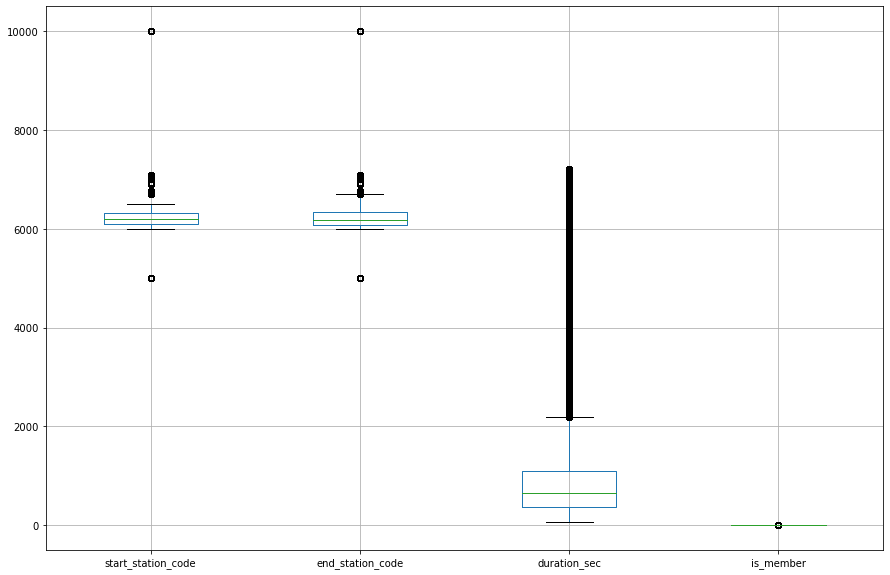

In [49]:
df.boxplot()

plt.show()

In [50]:
df.profile_report()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Some observations:
* Not too many surprises, but interestingly:
    * No nulls or nans - clean data in that sense 
    * There is a clear up-tick in the number of users over the years, that's almost growing exponentially
    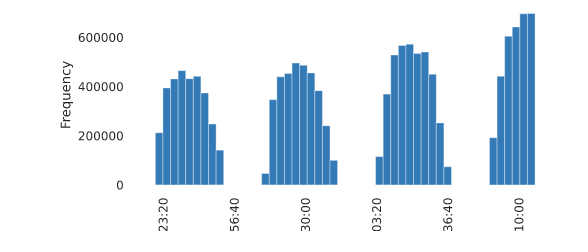
    
    * Some correlation between start and end points- presumably a lot of same location drop-offs:
    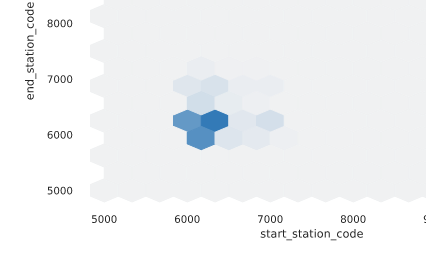
    * Some negative correlation between being a mamber and duration; Means non-members only rent the bike for longer rides:
    
    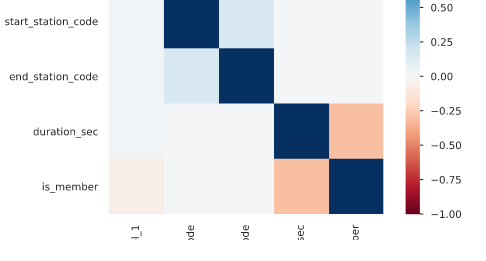
    
   
 * As expected, a log normal(or exponential?) distribution of the duration:
 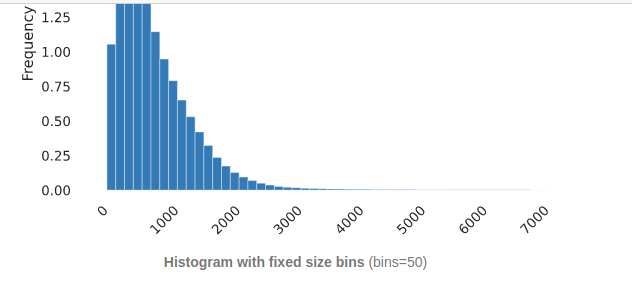
    
    

## 2. Initial visualizations 

### 2.1  duration_sec distribution

#### 2.1.1 Check for outliers

In [51]:
df.columns

Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')

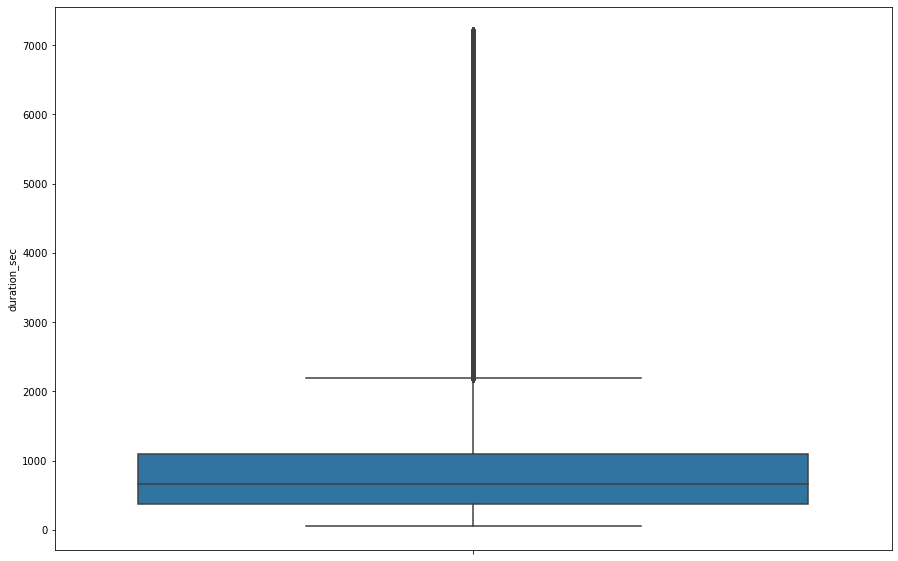

In [52]:
sns.boxplot(y="duration_sec", data = df)
plt.show()

The above chart suggests a number of outliers which is not ideal for duration_sec. 
May be because of  data issues. We will seek to resolve this using the elbow method. 

In [53]:
for q in np.linspace(0,1,11):
    print(q, ":", df.duration_sec.quantile(q))

0.0 : 61.0
0.1 : 229.0
0.2 : 326.0
0.30000000000000004 : 424.0
0.4 : 531.0
0.5 : 656.0
0.6000000000000001 : 803.0
0.7000000000000001 : 988.0
0.8 : 1231.0
0.9 : 1602.0
1.0 : 7199.0


In [54]:
import matplotlib.pyplot as plt

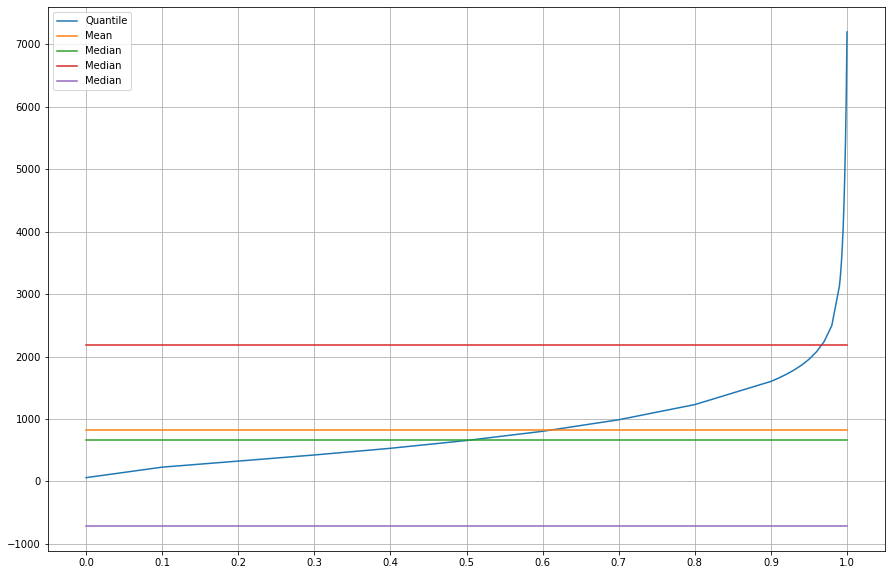

In [55]:
Q1 = df['duration_sec'].quantile(0.25)
Q3 = df['duration_sec'].quantile(0.75)
IQR = Q3 - Q1

q= np.hstack((np.linspace(0,0.9,10), np.linspace(0.91,0.99,9), np.linspace(0.991,1.0, 10)))
plt.plot(q, df.duration_sec.quantile(q), label = 'Quantile')
plt.plot(q, [df.duration_sec.mean()]*29, label='Mean')
plt.plot(q, [df.duration_sec.median()]*29 , label= 'Median')
plt.plot(q, [Q3+ 1.5 * IQR]*29 , label= 'Median')
plt.plot(q, [Q1-1.5 * IQR]*29 , label= 'Median')

plt.legend()
plt.grid(True)
plt.xticks(ticks = np.linspace(0,1,11))

plt.show()

In [56]:
for q in np.linspace(0.9,1,11):
    print(q, ":", df.duration_sec.quantile(q))

0.9 : 1602.0
0.91 : 1655.0
0.92 : 1714.0
0.93 : 1781.0
0.9400000000000001 : 1860.0
0.95 : 1956.0
0.96 : 2078.0
0.97 : 2242.0
0.98 : 2497.0
0.99 : 3128.0
1.0 : 7199.0


In [57]:
for q in np.linspace(0.99,1,11):
    print(q, ":", df.duration_sec.quantile(q))

0.99 : 3128.0
0.991 : 3252.0
0.992 : 3404.0
0.993 : 3584.0
0.994 : 3811.0
0.995 : 4090.0
0.996 : 4447.0
0.997 : 4895.0
0.998 : 5454.0
0.999 : 6191.0
1.0 : 7199.0


#### 2.1.2 Check for distribution of duration_sec

/home/santhosh/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


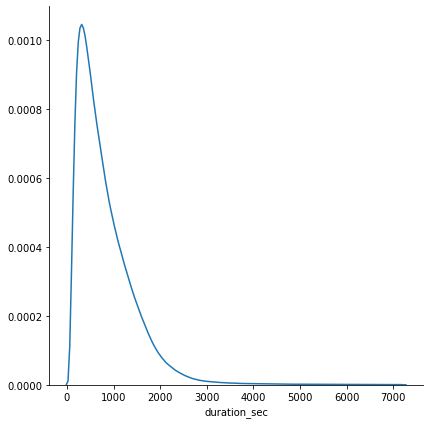

In [58]:
sns.FacetGrid(df, size=6)\
   .map(sns.kdeplot,"duration_sec")\
   .add_legend()

plt.show()

#Appears to look like a log normal pretty much

/home/santhosh/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


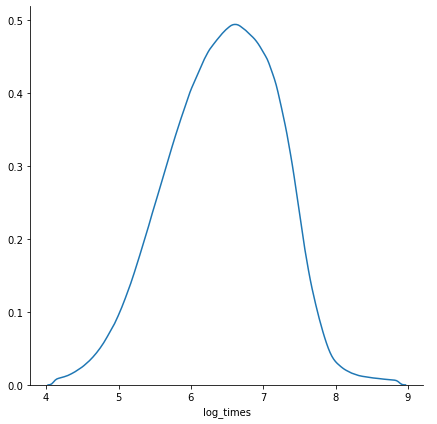

In [59]:
df['log_times']= np.log(df.duration_sec)
#pdf of log-values
sns.FacetGrid(df,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

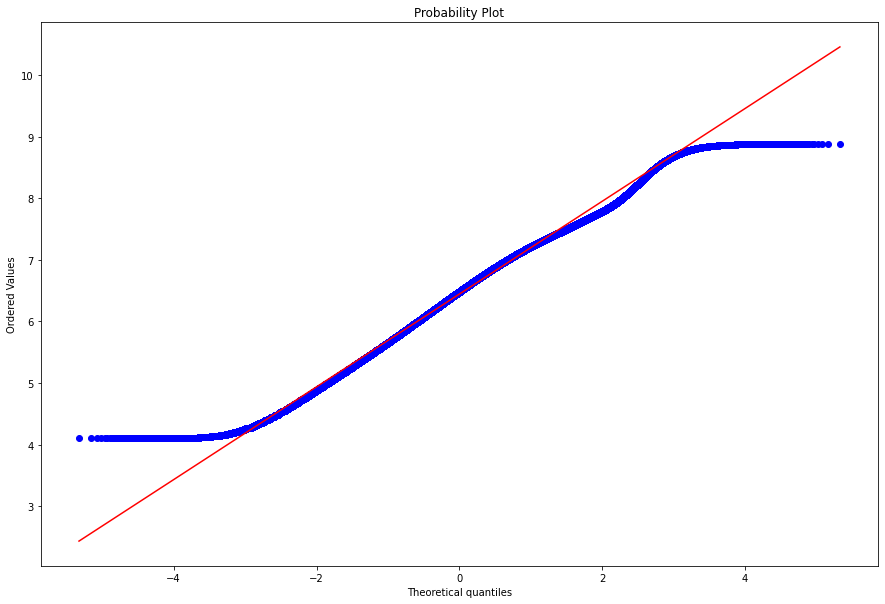

In [60]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(df['log_times'].values, plot=plt)
plt.show()

Clearly, this data is log-normal, but cleaned well and cut-off at T= 0 s (naturally) and T = 2 hrs,beyond which it is most likely a fringe case, e.g., the bikes were lost etc. 

Good news is that we don't need to spend too much time cleaning it. 


### 2.3 Station distribution visualizations

Here the first objective is to cluster the stations, otherwise, it's too many stations to visualize easily on a map

In [61]:
stations_df.category.value_counts()

Fully Matched             235
Added in 2017             214
Decommissioned in 2017     94
Other                       3
Name: category, dtype: int64

In [62]:
stations_info= df.groupby(by= [df.start_station_code])['duration_sec'].sum()

stations_info = pd.DataFrame(stations_info)

stations_info.columns = ['total_duration']

In [63]:
stations_info['total_trips'] = df.groupby(by= [df.start_station_code])['duration_sec'].count()

array([[<AxesSubplot:title={'center':'total_duration'}>,
        <AxesSubplot:title={'center':'total_trips'}>]], dtype=object)

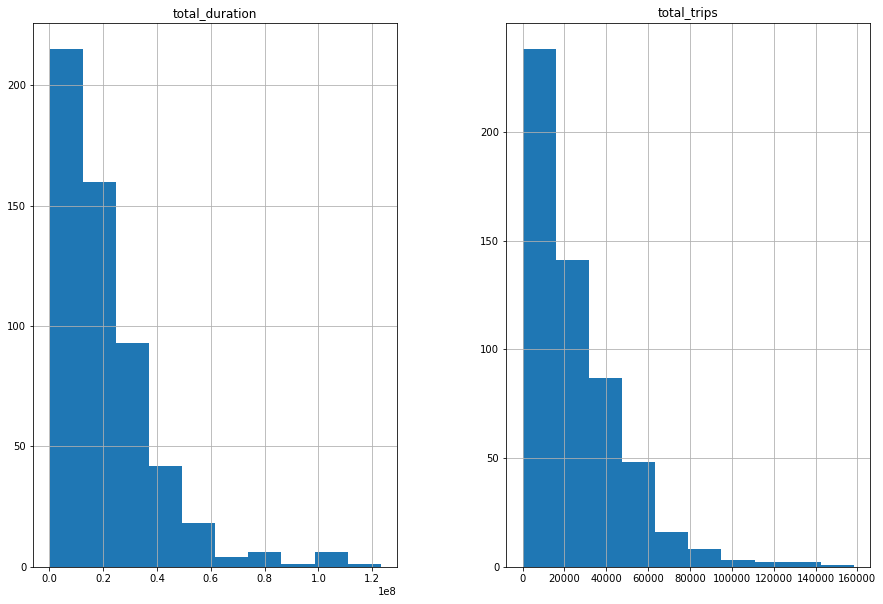

In [64]:
stations_info.hist()

### 2.4 Demand visualization by start_date time of day

In [65]:
year_time_dist = df.groupby(by =[df.start_date.dt.year, df.start_date.dt.time]).agg({"duration_sec":[np.sum, np.size]})

In [66]:
year_time_dist.index = year_time_dist.index.set_names(['Year', 'Time of day'])

year_time_dist.columns = year_time_dist.columns.get_level_values(1)

year_time_dist = year_time_dist.reset_index()

year_time_dist = year_time_dist.set_index('Year')

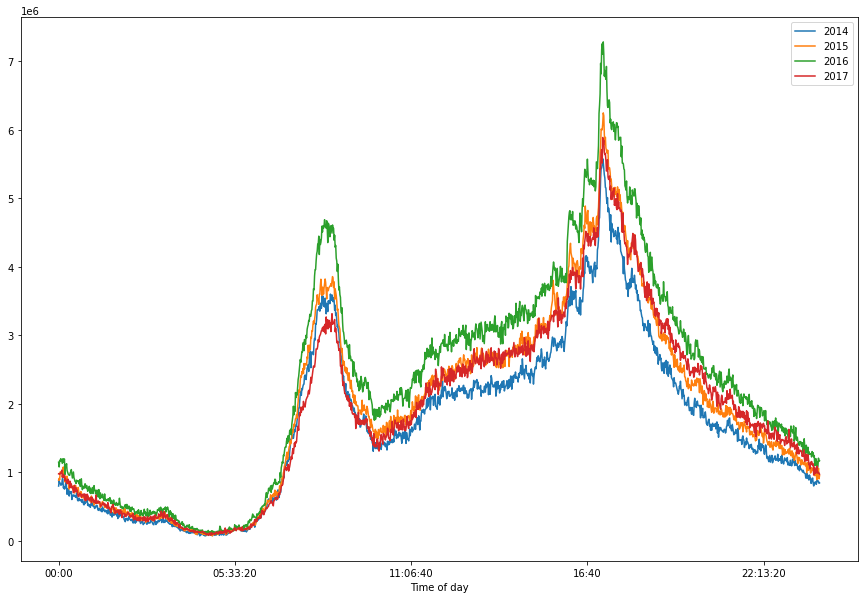

In [67]:
%matplotlib inline 


fig, axs = plt.subplots(figsize=(15,10))

year_time_dist.xs('2014').plot(x='Time of day', y='sum', label = '2014', ax = axs)
year_time_dist.xs('2015').plot(x='Time of day', y='sum', label = '2015', ax= axs)
year_time_dist.xs('2016').plot(x='Time of day', y='sum', label = '2016', ax= axs)
year_time_dist.xs('2017').plot(x='Time of day', y='sum', label = '2017', ax= axs)

plt.show()

In [68]:
axs.axis()

(-4317.0, 90657.0, -288389.60000000003, 7640709.6)

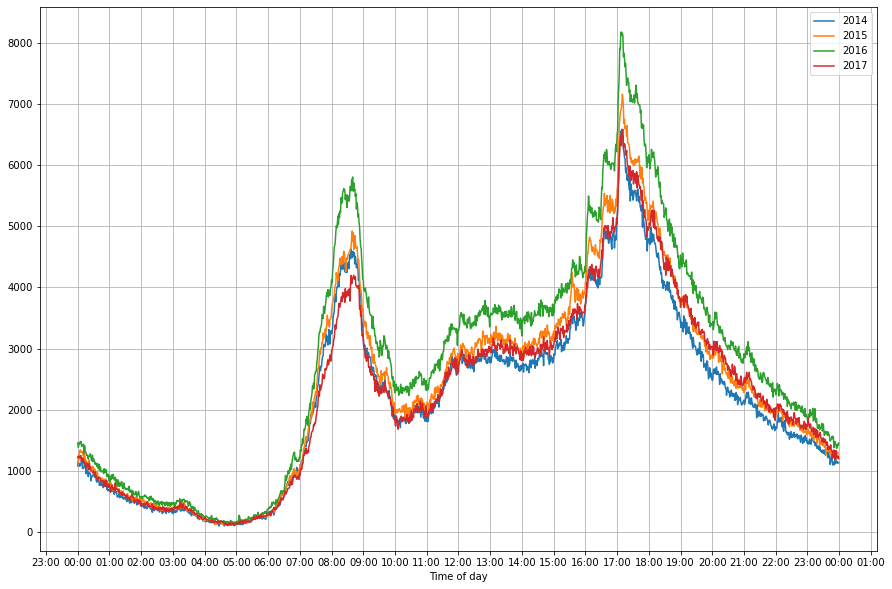

In [69]:
fig, axs = plt.subplots(figsize=(15,10))

year_time_dist.xs('2014').plot(x='Time of day', y='size',  label = '2014', ax = axs)
year_time_dist.xs('2015').plot(x='Time of day', y='size',  label = '2015', ax= axs)
year_time_dist.xs('2016').plot(x='Time of day', y='size',  label = '2016', ax= axs)
year_time_dist.xs('2017').plot(x='Time of day', y='size',  label = '2017', ax= axs)

axs.xaxis.set_major_locator(ticker.MultipleLocator(3600))
axs.grid(True)


plt.show()

Some key observations:

1. Clear peak during the mornings that's a steep rise between 8-9 am. 
2. and a more gradual rise from 3-5 pm. 
3. There are more users in the evening than during the morning rush and it does have a slow drip down after 5 pm 

### 2.5 Demand visualization by time of year

In [70]:
year_date_dist = df.groupby(by =[df.start_date.dt.year, df.start_date.dt.dayofyear]).agg({"duration_sec":[np.sum, np.size]})

In [71]:
year_date_dist.index = year_date_dist.index.set_names(['Year', 'Date of year'])

In [72]:
year_date_dist.columns = year_date_dist.columns.get_level_values(1)

year_date_dist = year_date_dist.reset_index(level=1)

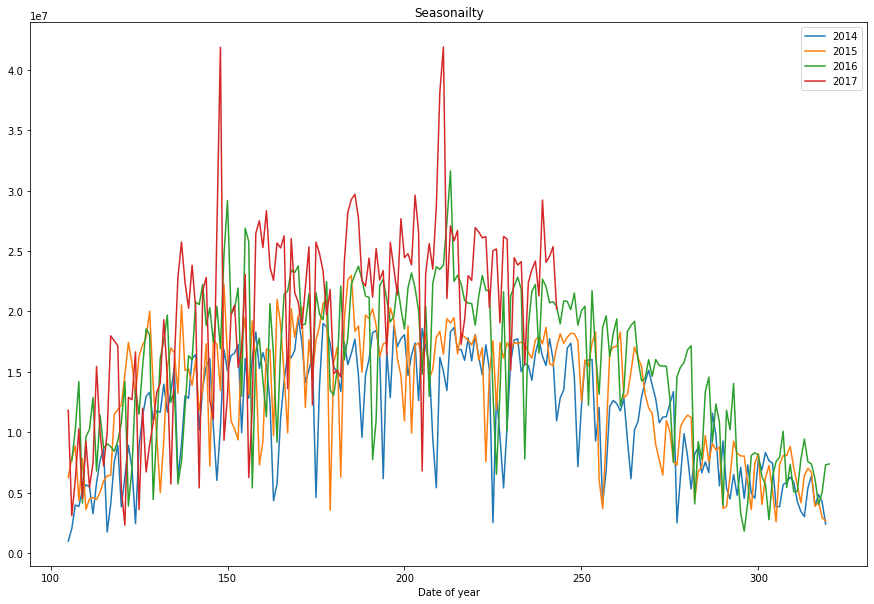

In [73]:
fig, axs = plt.subplots(figsize=(15,10))

year_date_dist.xs('2014').plot(x='Date of year', y='sum', label = '2014', ax = axs)
year_date_dist.xs('2015').plot(x='Date of year', y='sum', label = '2015', ax= axs)
year_date_dist.xs('2016').plot(x='Date of year', y='sum', label = '2016', ax= axs)
year_date_dist.xs('2017').plot(x='Date of year', y='sum', label = '2017', ax= axs)

axs.set_title('Seasonailty')

plt.show()

Clearly this chart doesn't show any thing useful because there's too much noise. An exponential moving average may be better. But in general:

1. Annual increase observed, as expected
2. Peak closer to day 200 of the year, which is Jun-July period. 
3. Huge rush when they do open around day 100. Business insight:->  Perhaps we can open a bit sooner and may get a slightly higher uptick

## 3. Data Cleaning 

It seems that the data is already quite clean and there is no need to additional clean the data. That is the current assumption. 4/18/2021, 16:40:22 IST

## 4. Feature Engineering 

### 4.1 Clustering the stations

In [50]:
stations_df.head()

name   latitude  longitude  Year_2014  \
code                                                                    
7015             LaSalle / 4e avenue  45.430740 -73.591911        NaN   
6715  Natatorium (LaSalle / Rolland)  45.444408 -73.575568        NaN   
7048                 Métro Angrignon  45.446534 -73.603541        NaN   
7056              Godin / Bannantyne  45.447554 -73.577263        NaN   
7051                 Jogues / Allard  45.449901 -73.600251        NaN   

      Year_2015  Year_2016  Year_2017       category  
code                                                  
7015        NaN        NaN     2017.0  Added in 2017  
6715        NaN        NaN     2017.0  Added in 2017  
7048        NaN        NaN     2017.0  Added in 2017  
7056        NaN        NaN     2017.0  Added in 2017  
7051        NaN        NaN     2017.0  Added in 2017

In [51]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo #Get the haversine distance

In [53]:
# we perform a basic clustering based on simplistic logic of distance 

coords= stations_df[['latitude','longitude']].values
neighbours= []

In [76]:
def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    stations_df['cluster'] = kmeans.predict(stations_df[['latitude', 'longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.4612362401836245 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.8322674736248178 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 24.0 
Min inter-cluster distance =  0.6539676684090463 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance 

In [54]:
# if check for the 60 clusters you can observe that there are two clusters with only 0.5 miles apart from each other
# so we choose 50 clusters for solve the further problem

# Getting 50 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=0).fit(coords)
stations_df['cluster'] = kmeans.predict(stations_df[['latitude', 'longitude']])

In [78]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[45.524673, -73.58255], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

In [79]:
stations_df.xs(6184)

name         Métro Mont-Royal (Rivard / du Mont-Royal)
latitude                                     45.524673
longitude                                    -73.58255
Year_2014                                       2014.0
Year_2015                                       2015.0
Year_2016                                       2016.0
Year_2017                                       2017.0
category                                 Fully Matched
cluster                                             38
Name: 6184, dtype: object

In [55]:
print(
    stations_df.latitude.min(), 
stations_df.latitude.max(),
stations_df.longitude.min(),
stations_df.longitude.max())

45.43074022417498 45.58275715603392 -73.67011472582817 -73.49506705999374


### 4.2  Plotting the stations clusters

In [81]:
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

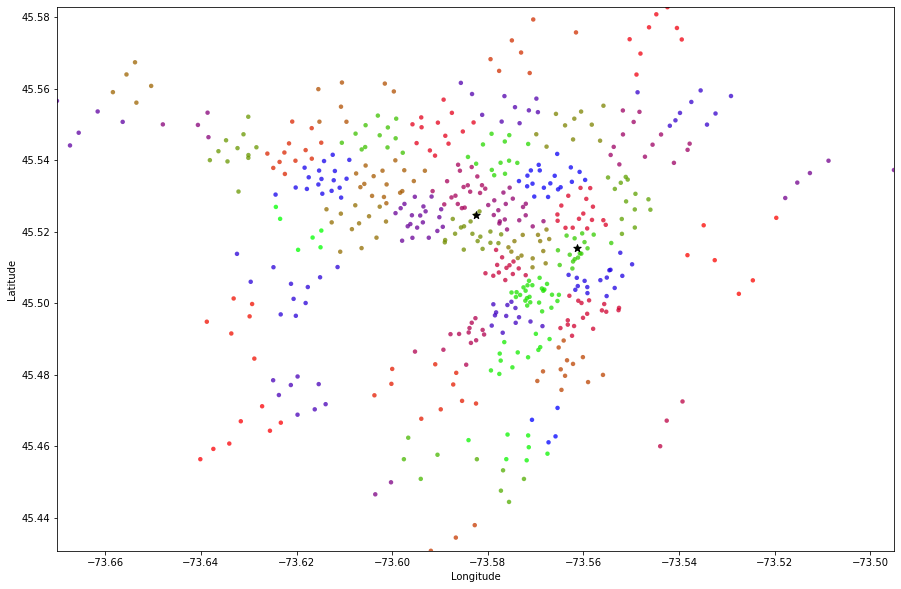

In [82]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-73.67011472582817, -73.49506705999374)
    city_lat_border = (45.43074022417498, 45.58275715603392)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,10))
    ax.scatter(frame.longitude.values, frame.latitude.values, s=20, lw=0,
               c=frame.cluster.values, cmap='brg', alpha=0.75)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.scatter(prio_points['longitude'], prio_points['latitude'], c='k',  marker='*', s=60, alpha=1) 
    
    plt.show()

plot_clusters(stations_df)

While 50 clusters is a bit too many , it does show that at the Metro Mont-Royal pick up point, it seems to belong to a cluster that was previously served by stations that were eventually replaced in 2017. So we need to pay attention to that, when the results are released. 

### 4.2_ Merging cluster info into df

In [136]:
df['start_cluster'] = df.merge(stations_df['cluster'], left_on='start_station_code', right_index=True)['cluster']

In [141]:
df['end_cluster'] = df.merge(stations_df['cluster'], left_on= 'end_station_code', right_index=True)['cluster']

The following suggests the number of "trips" for each bucket (cluster, date), based on the size of the dataframe. Gives that there's no "smoothing" that's necessary:

In [58]:
df.shape[0]/50/(120*3 + 90)

38.19871111111111

Reviewing the number of possible pairs. 

In [59]:
start_end_pairs= (df['start_station_code'].map(str)+ '-' + df['end_station_code'].map(str))

In [91]:
start_end_pairs.nunique()

221970

In [92]:
546*546

298116

In [93]:
221970/298116

0.7445759368836292

There are slightly fewer than the maximum number of pairs, around 75%. 

#### Merging the test data with the clusters info as well

In [60]:
# Step 1: add the clusters by merging

test_demand = test_demand.merge(stations_df['cluster'], left_on= 'start_station_code', right_index=True)
test_demand = test_demand.rename(columns = {'cluster':'start_cluster'})

In [61]:
test_demand = test_demand.merge(stations_df['cluster'], left_on= 'end_station_code', right_index=True)
test_demand = test_demand.rename(columns = {'cluster':'end_cluster'})

In [62]:
# Step 2: Filtering only the clusters that matter
test_prio = test_demand[(test_demand['start_cluster']==38) & (test_demand['end_cluster']==44)]

In [63]:
test_prio['start_date'] = pd.to_datetime(test_prio['start_date'])

<ipython-input-63-f23c7c2d6e3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prio['start_date'] = pd.to_datetime(test_prio['start_date'])


In [64]:
# Step 3: Group by day 
test = test_prio.groupby(by=[test_prio.start_date.dt.date, 'is_member']).agg({'duration_sec': [np.sum, np.size]})


#Note that we are predicting against the prio points clusters here, which is fine

In [65]:
test = test.reset_index(level=1)

In [66]:
test = test.pivot(columns= 'is_member')
test.columns = test.columns.droplevel()

In [67]:
test.columns = ['non_member_duration', 'member_duration', 'non_member_rides', 'member_rides']

In [68]:
test['total_rides'] = test.non_member_rides + test.member_rides
test['total_duration'] = test['non_member_duration'] + test['member_duration']

In [69]:
test_full = test
# df that contains the member non-member splits

In [70]:
test = test_full['total_rides']

### 4.3 Time binning only

In [94]:
df_by_date = df.groupby(by=[df.start_date.dt.date, 'start_station_code','end_station_code', 'is_member']).agg({"duration_sec":[np.sum, np.size]})

df_by_date= df_by_date.reset_index(level=3)

df_by_date= (df_by_date.pivot(columns='is_member')).fillna(0)

print(df_by_date.columns)

df_by_date[('duration_sec', 'sum', 'Total')] = (df_by_date[('duration_sec', 'sum', True)] + \
                                                        df_by_date[('duration_sec', 'sum', False)])

df_by_date[('duration_sec', 'size', 'Total')] = (df_by_date[('duration_sec', 'size', True)] + \
                                                        df_by_date[('duration_sec', 'size', False)])


MultiIndex([('duration_sec',  'sum', False),
            ('duration_sec',  'sum',  True),
            ('duration_sec', 'size', False),
            ('duration_sec', 'size',  True)],
           names=[None, None, 'is_member'])


In [95]:
df_by_date.shape

(9686139, 6)

In [96]:
df_by_date.iloc[:,5].mean()

1.4300130320244218

An average start-end station pair only receives ~1.5 rides per day. 

In [97]:
df.groupby(by=[df.start_date.dt.date, 'start_station_code']).agg({"duration_sec":[np.size]})

duration_sec
                                      size
start_date start_station_code             
2014-04-15 5007                          1
           6001                          5
           6003                          1
           6008                          2
           6009                          5
...                                    ...
2017-08-31 7078                         23
           7079                         37
           7080                         80
           7081                         28
           10002                        92

[357391 rows x 1 columns]

In [98]:
_[('duration_sec','size')].mean()

38.756725826895476

At any given starting station, there are approximately ~38 rides per day; which are quite log-normal, as verified in Section 2.3

### 4.4 Time binning and clustering

The question is interested in daily forecast. Hence, we only care about daily numbers at this time.  So we will bin demand into bins of each day. 

In [142]:
cluster_df_by_date = df.groupby(by=[df.start_date.dt.date, 'start_cluster','end_cluster', 'is_member']).agg({"duration_sec":[np.sum, np.size]})

cluster_df_by_date= cluster_df_by_date.reset_index(level=3)

cluster_df_by_date= (cluster_df_by_date.pivot(columns='is_member')).fillna(0)

cluster_df_by_date.columns

cluster_df_by_date[('duration_sec', 'sum', 'Total')] = (cluster_df_by_date[('duration_sec', 'sum', 1)] + \
                                                        cluster_df_by_date[('duration_sec', 'sum', 0)])

cluster_df_by_date[('duration_sec', 'size', 'Total')] = (cluster_df_by_date[('duration_sec', 'size', 1)] + \
                                                        cluster_df_by_date[('duration_sec', 'size', 0)])


<AxesSubplot:xlabel='start_date'>

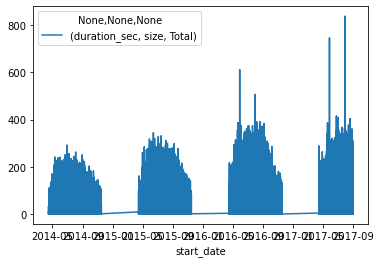

In [100]:
cluster_df_by_date.reset_index().plot(x= 'start_date', y= ('duration_sec', 'size', 'Total') )

In [143]:
cluster_df_by_date.columns = ['total_duration_members', 'total_duration_non_members',
                              'rides_count_members', 'rides_count_non_members',
                             'total_duration_all', 'rides_count_all']

cluster_df_by_date.head(20)

total_duration_members  \
start_date start_cluster end_cluster                           
2014-04-15 1             1                               0.0   
                         2                               0.0   
                         3                            1029.0   
                         5                               0.0   
                         8                             827.0   
                         10                              0.0   
                         14                              0.0   
                         15                              0.0   
                         16                              0.0   
                         18                              0.0   
                         19                              0.0   
                         21                              0.0   
                         36                              0.0   
                         37                              0.0   
                         38                           1751.0   
                         40                              0.0   
                         44                              0.0   
                         45                              0.0   
                         46                              0.0   
           2             2                               0.0   

                                      total_duration_non_members  \
start_date start_cluster end_cluster                               
2014-04-15 1             1                                2956.0   
                         2                                1588.0   
                         3                                6127.0   
                         5                                1218.0   
                         8                                 599.0   
                         10                               3093.0   
                         14                               3119.0   
                         15                                922.0   
                         16                               2894.0   
                         18                               1678.0   
                         19                               2778.0   
                         21                               2446.0   
                         36                               5405.0   
                         37                                420.0   
                         38                               4999.0   
                         40                               3622.0   
                         44                               3922.0   
                         45                               1203.0   
                         46                               7355.0   
           2             2                                 977.0   

                                      rides_count_members  \
start_date start_cluster end_cluster                        
2014-04-15 1             1                            0.0   
                         2                            0.0   
                         3                            1.0   
                         5                            0.0   
                         8                            1.0   
                         10                           0.0   
                         14                           0.0   
                         15                           0.0   
                         16                           0.0   
                         18                           0.0   
                         19                           0.0   
                         21                           0.0   
                         36                           0.0   
                         37                           0.0   
                         38                           2.0   
                         40                           0.0   
                         44       

### 4.5 Time binning and clustering for prio _points

In [82]:
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

In [158]:
prio_clusters_daily_rides = cluster_df_by_date.reset_index(level=0).xs((38, 44))

/home/santhosh/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [159]:
prio_clusters_daily_rides= prio_clusters_daily_rides.reset_index(drop=True)
prio_clusters_daily_rides= prio_clusters_daily_rides.set_index('start_date')

<AxesSubplot:xlabel='start_date'>

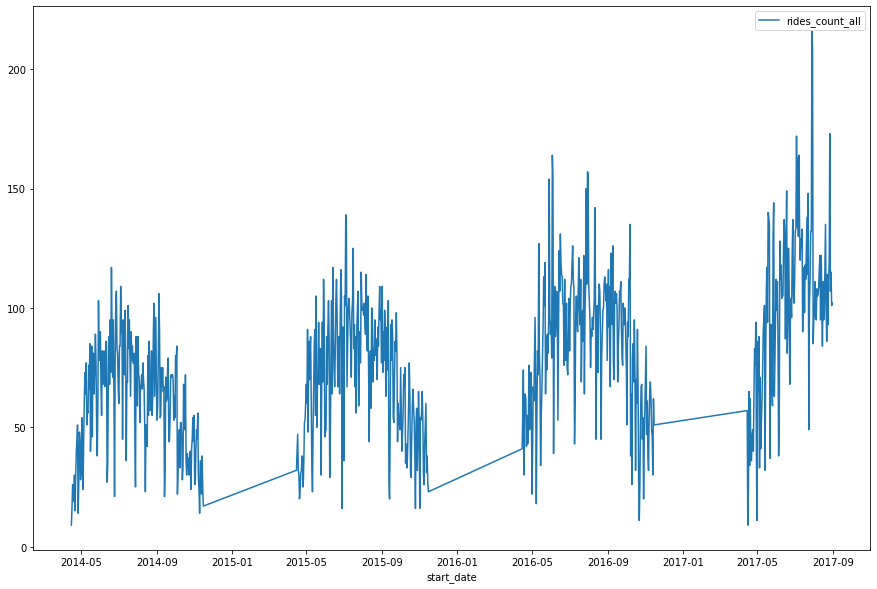

In [160]:
prio_clusters_daily_rides.plot( y= 'rides_count_all')

## 5. Time Series Analysis

This section attempts to use the SARIMAX model which compromises of the Seasonal, Auto-correlation, Integrated (difference), and Moving Average approaches to provide a daily forecast for trips originating from 6184 to 6015, for the week of Sept 4th 2017.

The simplest approach is to find the demand for the cluster-pair we are concerned about. 

Hence, we will focus on the demand from cluster 44 to cluster 38

In [216]:
#First we check for stationarity
result = adfuller(prio_clusters_daily_rides['rides_count_all'])

In [217]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(result):
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [218]:
adfuller_test(result)

ADF Test Statistic : -2.349834039126548
p-value : 0.15639858288399378
#Lags Used : 13
Number of Observations Used : 770
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Not surprising at all that it's non-stationary. We now try to do some kind of differencing

In [112]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [220]:
train = prio_clusters_daily_rides['rides_count_all']

In [221]:
arima_model = auto_arima(train.loc[dt.date(2017,1,1):], start_p= 0, d=1, start_q= 0, max_p= 5, max_d= 5, max_q= 5, 
                         start_P=0, D=1, start_Q = 0, max_P= 5, max_D=5, m = 7, season=True, 
                         error_action = 'warn', trace= True, supress_warnings = True, stepwise =True, 
                        random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1332.832, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1297.254, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=1249.424, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1308.225, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=1251.409, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=1251.403, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1284.304, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=1251.903, Time=0.23 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1277.670, Time=0.05 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=1240.268, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=1242.202, Time=0.29 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=1242.171, Time=0.34 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=1

In [222]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -616.134
Date:                           Mon, 19 Apr 2021   AIC                           1240.268
Time:                                   21:13:26   BIC                           1251.768
Sample:                                        0   HQIC                          1244.941
                                           - 139                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3323      0.083      4.007      0.000       0.170       0.495
ma.L1         -0.9238      0.050    -18.325      0.000      -1.023      -0.825
ma.S.L7       -0.8030      0.080     -9.987      0.000      -0.961      -0.645
sigma2       661.3335     84.625      7.815      0.000     495.472     827.195
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.92   Prob(JB):                         0.46
Heteroskedasticity (H):               0.95   Skew:                             0.23
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
base = dt.date(2017,9,1)
numdays = 11
date_list = [base + dt.timedelta(days=x) for x in range(numdays)]

minor_ticks = [dt.date(2017,4,1) + dt.timedelta(days=x) for x in range(0,180,7)]

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=11), index=date_list)

prediction.columns = ['Predicted rides']

In [290]:
prediction = pd.Series(prediction['Predicted rides'])

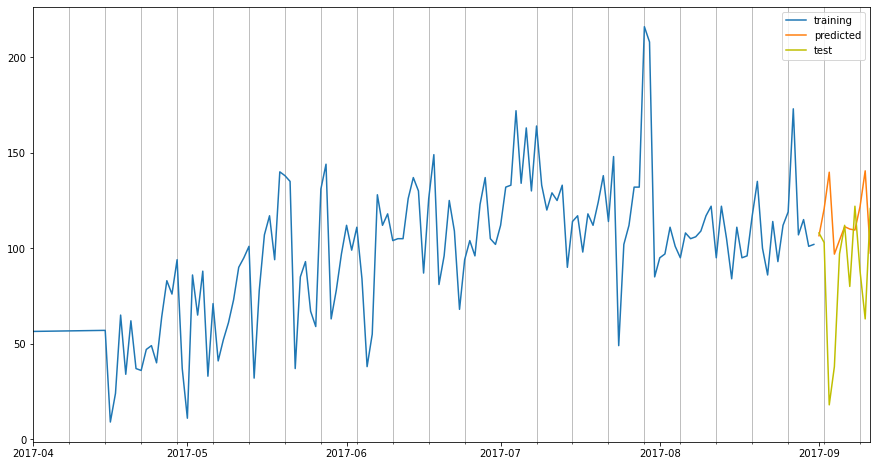

In [274]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train, label='training')
plt.plot(prediction, label='predicted')
plt.plot(test,label = 'test', c= 'y')
plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

While this simplistic model fails to appreciate the annual seasonality (e.g., the demand decreases as we go later in the year), the moving average part of the ARIMA will capture it for short term predictions. 

Hence, this model would need to 'updated' regularly. 


The weekly pattern is very clear and we definitely see that the ARIMA does predict it. 

The significant concern here is that we are faily to appreciate the "monthly seasonality" that we may have learnt from the past year's data. Indeed, we can safely assume that this "learning" is not that useful because we only have a few months of data. 

A visual inspection suggests that the ARIMA model is failing to observe the seasonal decrease that comes through September (i.e., the moving average part is not getting updated properly)

In [298]:
prediction_week = prediction.loc[dt.date(2017,9,4):dt.date(2017,9,11)]

In [299]:
test_week = test.loc[dt.date(2017,9,4):dt.date(2017,9,11)]

In [300]:
# Let us now estimate the errors in these predictions:

MAPE(test_week,prediction_week)

0.4898194837552839

In [301]:
RMSE(test_week,prediction_week)

39.19741142616697

In [85]:
MAPE_analysis = {} 
RMSE_analysis = {}

In [86]:
MAPE_analysis ['timeseries'] = 0.4898194837552839
RMSE_analysis ['timeseries'] = 39.19741142616697


These don't look great, but the issue is not surprising, the Moving average part, 
which adjusts for the decreasing momentum does not get updated for longer term predictions (i.e., more than one period) 

## 6. Machine Learning based predictions

In this section we will try to predict based on 3 different models: Linear Regression, Random Forest and XGBoost. 

### 6.1 Define the features

In [161]:
day_of_week = pd.get_dummies(pd.to_datetime(pd.Series(prio_clusters_daily_rides.index)).dt.dayofweek, drop_first = True).\
rename(columns= {1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'})

In [162]:
day_of_week.index = prio_clusters_daily_rides.index

In [163]:
prio_clusters_daily_rides = pd.concat([prio_clusters_daily_rides, day_of_week], axis=1)

In [164]:
prio_clusters_clean = prio_clusters_daily_rides.loc[dt.date(2017,1,1):dt.date(2017,12,31)]

In [165]:
prio_clusters_clean.columns

Index(['total_duration_members', 'total_duration_non_members',
       'rides_count_members', 'rides_count_non_members', 'total_duration_all',
       'rides_count_all', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],
      dtype='object')

In [166]:
train_Y= prio_clusters_clean['rides_count_all']
#This defines the Y for the regression

In [167]:
prio_clusters_clean = prio_clusters_clean[['rides_count_members', 'rides_count_non_members', 'total_duration_all', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']]

In [168]:
prio_clusters_clean.columns  = pd.MultiIndex.from_product([['today'],prio_clusters_clean.columns])

In [169]:
prio_prev_days = [0]*3
for i in range(3):
    prio_prev_days[i]= prio_clusters_clean[ pd.MultiIndex.from_product([['today'],['rides_count_members', 'rides_count_non_members', 'total_duration_all']])
                                 ].shift(1+i)
    prio_prev_days[i].columns  = pd.MultiIndex.from_product([[f't{i+1}'],
                                                   ['rides_count_members', 'rides_count_non_members', 'total_duration_all']])

In [170]:
prio_prev_years = [0]*2 
for i in range(2):
    prio_prev_years[i] = pd.Series(prio_clusters_clean.index, name = ('today', f'year_minus_{i}'))\
                        .apply(lambda x: dt.date(x.year-1, x.month, x.day))\
                        .apply(lambda x: prio_clusters_daily_rides['rides_count_all'].xs(x))
    prio_prev_years[i].index  = prio_clusters_clean.index 

In [171]:
train_X_1 = pd.concat(prio_prev_days + prio_prev_years, axis=1)

In [298]:
day_of_week.columns = pd.MultiIndex.from_product([['today'],day_of_week.columns])

In [299]:
train_X = pd.concat([train_X_1, day_of_week.loc[dt.date(2017,1,1): dt.date(2017,12,31)]], axis =1).dropna()

In [301]:
train_X.columns

MultiIndex([(   't1',     'rides_count_members'),
            (   't1', 'rides_count_non_members'),
            (   't1',      'total_duration_all'),
            (   't2',     'rides_count_members'),
            (   't2', 'rides_count_non_members'),
            (   't2',      'total_duration_all'),
            (   't3',     'rides_count_members'),
            (   't3', 'rides_count_non_members'),
            (   't3',      'total_duration_all'),
            ('today',            'year_minus_0'),
            ('today',            'year_minus_1'),
            ('today',                    'Tues'),
            ('today',                     'Wed'),
            ('today',                   'Thurs'),
            ('today',                     'Fri'),
            ('today',                     'Sat'),
            ('today',                     'Sun')],
           )

In [174]:
train_Y

start_date
2017-04-15     57.0
2017-04-16      9.0
2017-04-17     24.0
2017-04-18     65.0
2017-04-19     34.0
              ...  
2017-08-27    173.0
2017-08-28    107.0
2017-08-29    115.0
2017-08-30    101.0
2017-08-31    102.0
Name: rides_count_all, Length: 139, dtype: float64

In [175]:
test_full.columns

Index(['non_member_duration', 'member_duration', 'non_member_rides',
       'member_rides', 'total_rides', 'total_duration'],
      dtype='object')

In [176]:
test_full = test_full.rename(columns={'member_rides': 'rides_count_members', 'non_member_rides':'rides_count_non_members', 'total_duration':'total_duration_all'})

In [177]:
day_of_week_test = pd.get_dummies(pd.to_datetime(pd.Series(test_full.index)).dt.day_of_week, drop_first=True).\
rename(columns =  {1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'})

day_of_week_test.index = test_full.index 

day_of_week_test.columns = pd.MultiIndex.from_product([['today'], day_of_week_test.columns])

In [178]:
test_full

non_member_duration  member_duration  rides_count_non_members  \
start_date                                                                  
2017-09-01                25715            49766                       23   
2017-09-02                37813            48820                       40   
2017-09-03                 1716             8775                        3   
2017-09-04                14204            20357                       12   
2017-09-05                10769            54266                       15   
2017-09-06                12350            56437                       17   
2017-09-07                 9036            44686                       12   
2017-09-08                17364            67407                       20   
2017-09-09                30586            50573                       23   
2017-09-10                18772            29668                       20   
2017-09-11                 8359            69838                       13   
2017-09-12                11266            48952                       14   
2017-09-13                18030            63918                       23   
2017-09-14                22584            75558                       26   
2017-09-15                16383            53306                       21   
2017-09-16                41057            32561                       42   
2017-09-17                24870            49718                       27   
2017-09-18                16252            49446                       18   
2017-09-19                 6060            66895                        8   
2017-09-20                14556            63314                       19   
2017-09-21                20290            76955                       26   
2017-09-22                24821            68361                       27   
2017-09-23                34326            74481                       42   
2017-09-24                47286            44560                       47   
2017-09-25                21635            60269                       19   
2017-09-26                19328            69692                       19   
2017-09-27                 6491            48971                       10   
2017-09-28                 8918            52862                       10   
2017-09-29                14602            61089                       12   
2017-09-30                24849            45218                       28   

            rides_count_members  total_rides  total_duration_all  
start_date                                                        
2017-09-01                   85          108               75481  
2017-09-02                   63          103               86633  
2017-09-03                   15           18               10491  
2017-09-04                   26           38               34561  
2017-09-05                   82           97               65035  
2017-09-06                   95          112               68787  
2017-09-07                   68           80               53722  
2017-09-08                  102          122               84771  
2017-09-09                   65           88               81159  
2017-09-10                   43           63               48440  
2017-09-11                  108          121               78197  
2017-09-12                   80           94               60218  
2017-09-13                   94          117               81948  
2017-09-14                  110          136               98142  
2017-09-15                   83          104               69689  
2017-09-16                   48           90               73618  
2017-09-17                   72           99               74588  
2017-09-18                   77           95               65698  
2017-09-19                  109          117               72955  
2017-09-20                   91          110               77870  
2017-09-21                  124          150               97245  
2017-0

In [179]:
test_full.columns  = pd.MultiIndex.from_product([['today'],test_full.columns])

In [180]:
prio_prev_days_test = [0]*3
for i in range(3):
    prio_prev_days_test[i]= test_full[ pd.MultiIndex.from_product([['today'],['rides_count_members', 'rides_count_non_members', 'total_duration_all']])
                                 ].shift(1+i)
    prio_prev_days_test[i].columns  = pd.MultiIndex.from_product([[f't{i+1}'],
                                                   ['rides_count_members', 'rides_count_non_members', 'total_duration_all']])

In [181]:
test_full.columns

MultiIndex([('today',     'non_member_duration'),
            ('today',         'member_duration'),
            ('today', 'rides_count_non_members'),
            ('today',     'rides_count_members'),
            ('today',             'total_rides'),
            ('today',      'total_duration_all')],
           )

In [182]:
prio_prev_years_test = [0]*2 
for i in range(2):
    prio_prev_years_test[i] = pd.Series(test_full.index, name = ('today', f'year_minus_{i}'))\
                        .apply(lambda x: dt.date(x.year-1, x.month, x.day))\
                        .apply(lambda x: prio_clusters_daily_rides['rides_count_all'].xs(x))
    prio_prev_years_test[i].index  = test_full.index 

In [183]:
test_X_1 = pd.concat(prio_prev_days_test + prio_prev_years_test, axis=1)

In [184]:
test_X = pd.concat([test_X_1, day_of_week_test], axis =1).dropna()

In [185]:
test_Y = test_full[('today','total_rides')]

In [186]:
test_Y

start_date
2017-09-01    108
2017-09-02    103
2017-09-03     18
2017-09-04     38
2017-09-05     97
2017-09-06    112
2017-09-07     80
2017-09-08    122
2017-09-09     88
2017-09-10     63
2017-09-11    121
2017-09-12     94
2017-09-13    117
2017-09-14    136
2017-09-15    104
2017-09-16     90
2017-09-17     99
2017-09-18     95
2017-09-19    117
2017-09-20    110
2017-09-21    150
2017-09-22    134
2017-09-23    144
2017-09-24    117
2017-09-25    113
2017-09-26    117
2017-09-27     86
2017-09-28     98
2017-09-29    106
2017-09-30     94
Name: (today, total_rides), dtype: int64

In [187]:
print(train_X.shape, train_Y.shape)

(136, 17) (139,)


In [188]:
print(test_X.shape, test_Y.shape)

(27, 17) (30,)


In [189]:
train_Y= train_Y[3:]
test_Y= test_Y[3:]

### 6.2 Run the regression 

In [190]:
from sklearn.linear_model import LinearRegression

lr_reg=LinearRegression().fit(train_X, train_Y)

y_pred = lr_reg.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)

y_pred = lr_reg.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index).apply(round)



In [191]:
MAPE(test_Y,pred_Y)

0.2016839696077612

In [192]:
RMSE(test_Y,pred_Y)

29.11026292233389

In [193]:
MAPE_analysis ['linreg'] = 0.2016839696077612
RMSE_analysis ['linreg'] = 29.11026292233389

**Significant improvement over the time series, in terms of the error**

In [195]:
#minor_ticks = [dt.date(2017,4,1) + dt.timedelta(days=x) for x in range(0,180,7)]

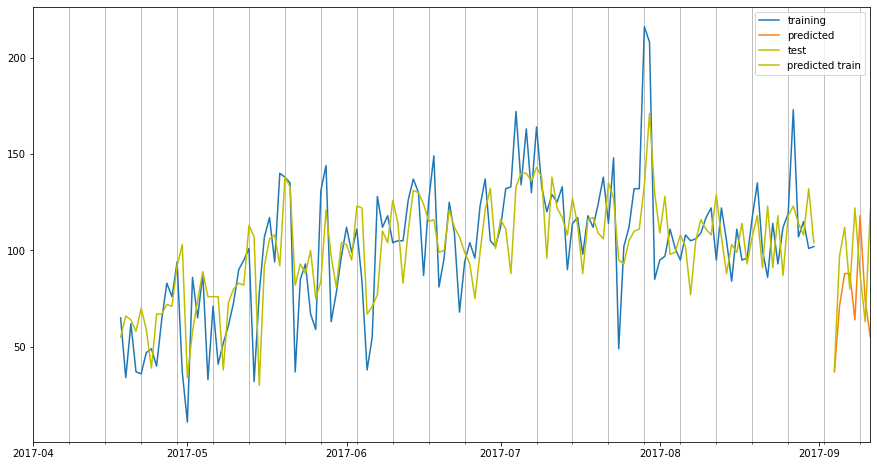

In [196]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

### 6.3 Random Forest

#### 6.3.1 The heuristically chosen random forest model analysis

In [197]:
regr1 = RandomForestRegressor(max_features='sqrt',
                              min_samples_leaf=4,
                              min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(train_X, train_Y)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [198]:
regr1.get_params()

#We focus on the following parameters: n_estimators, 
#max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [199]:
y_pred = regr1.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)

y_pred = regr1.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index).apply(round)


In [200]:
MAPE(test_Y,pred_Y)

0.21382804332699099

In [201]:
RMSE(test_Y,pred_Y)

26.243164894953193

In [202]:
MAPE_analysis ['rf_heuristic'] = Out[200]
RMSE_analysis ['rf_heuristic'] = Out[201]

**Some improvement over the time series, but not better than the linear regressor**

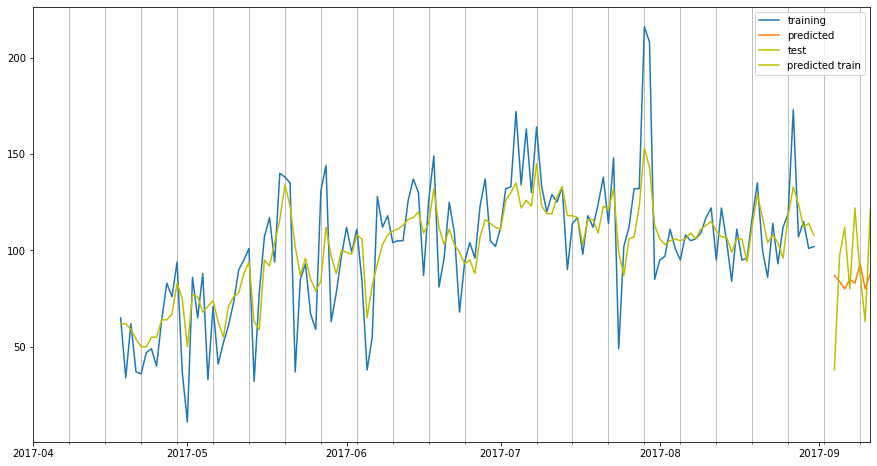

In [203]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

#### 6.3.2 Randomized Search on Random Forest Model

In [204]:
n_estimators = [x for x in range(10,100,10)]
max_features = ['auto', 'sqrt']
max_depth = [x for x in range(11,110,11)]
max_depth.append(None)
min_samples_split = [2,3,5,10]
min_samples_leaf = [2,3,4,5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [11, 22, 33, 44, 55, 66, 77, 88, 99, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3, 4, 5],
 'min_samples_split': [2, 3, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90]}


In [205]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [206]:
rf_random.fit(train_X,train_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [11, 22, 33, 44, 55, 66,
                                                      77, 88, 99, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90]},
                   random_state=42, verbose=2)

In [207]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [208]:
y_pred = rf_random.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)

y_pred = rf_random.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index).apply(round)


In [209]:
MAPE(test_Y,pred_Y)

0.2573403899381213

In [210]:
RMSE(test_Y,pred_Y)

32.093036050878126

In [211]:
MAPE_analysis ['rf_rdsearch'] = Out[209]
RMSE_analysis ['rf_rdsearch'] = Out[210]

** slightly better interms of RMSE compared to the heuristic Random forest**

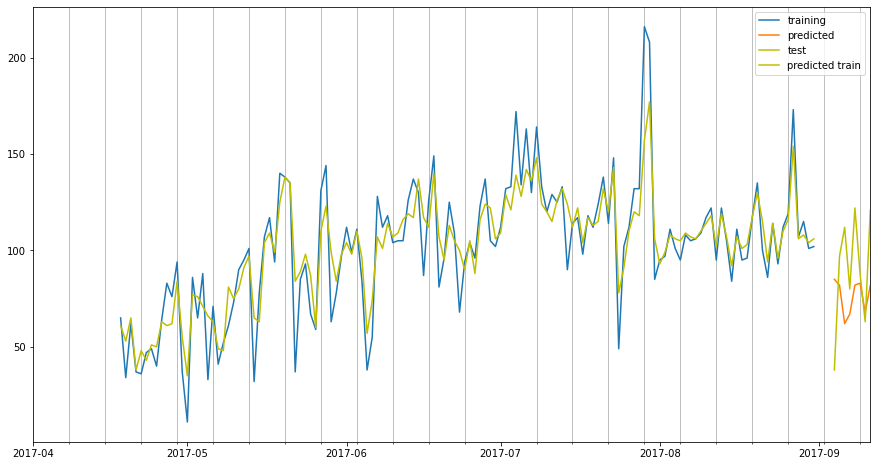

In [212]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

#### 6.3.3 Grid Search on Random Forest Model

In [213]:
n_estimators = [x for x in range(4,21,3)]
max_features = ['auto', 'sqrt']
max_depth = [x for x in range(8,13,1)]
max_depth.append(None)
min_samples_split = [2,3,5,10]
min_samples_leaf = [2,3,4,5]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(grid)

{'bootstrap': [True, False],
 'max_depth': [8, 9, 10, 11, 12, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 3, 4, 5],
 'min_samples_split': [2, 3, 5, 10],
 'n_estimators': [4, 7, 10, 13, 16, 19]}


In [214]:
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, 
                               param_grid = grid, 
                             cv =5, verbose=2, n_jobs = -1)

In [215]:
rf_grid.fit(train_X,train_Y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [8, 9, 10, 11, 12, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [4, 7, 10, 13, 16, 19]},
             verbose=2)

In [216]:
list(filter(lambda x: x.find('params')+1, dir(regr1)))

['estimator_params', 'get_params', 'set_params']

In [217]:
regr1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [218]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [219]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 4}

In [220]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 4}

In [221]:
y_pred = rf_grid.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)

y_pred = rf_grid.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index).apply(round)


In [222]:
MAPE(test_Y,pred_Y)

0.21273641800928164

In [223]:
RMSE(test_Y,pred_Y)

27.54255965941787

In [542]:
MAPE_analysis ['rf_gridsearch'] = Out[539]
RMSE_analysis ['rf_gridsearch'] = Out[540]

In [224]:
MAPE_analysis ['rf_gridsearch_cv5'] = Out[222]
RMSE_analysis ['rf_gridsearch_cv5'] = Out[223]

In [225]:
MAPE_analysis

{'timeseries': 0.4898194837552839,
 'linreg': 0.2016839696077612,
 'rf_heuristic': 0.21382804332699099,
 'rf_rdsearch': 0.2573403899381213,
 'rf_gridsearch_cv5': 0.21273641800928164}

In [226]:
RMSE_analysis

{'timeseries': 39.19741142616697,
 'linreg': 29.11026292233389,
 'rf_heuristic': 26.243164894953193,
 'rf_rdsearch': 32.093036050878126,
 'rf_gridsearch_cv5': 27.54255965941787}

**slightly better than randomized search, but not that much better than heuristic Random forest**

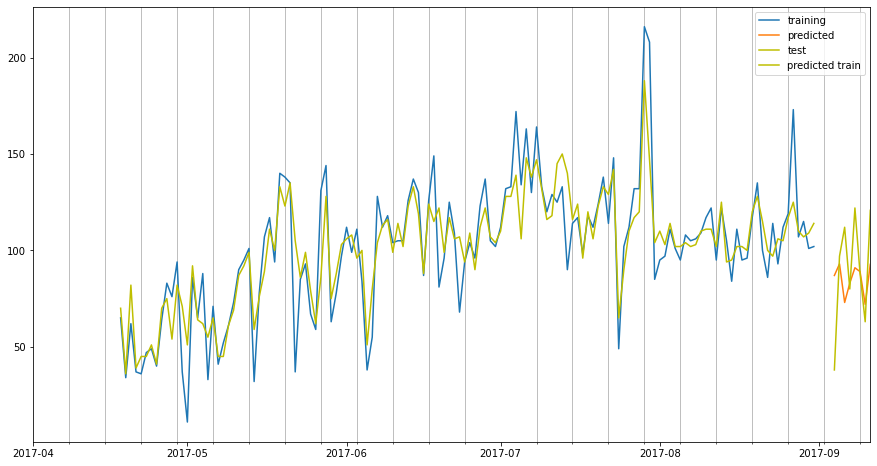

In [227]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

### 6.4 XGBoost

#### 6.4.1 XGBoost heuristic choice

In [228]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=200, reg_lambda=200, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [229]:
y_pred = x_model.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)

y_pred = x_model.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index).apply(round)


/home/santhosh/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [230]:
MAPE(test_Y,pred_Y)

0.30550213828549116

In [231]:
RMSE(test_Y,pred_Y)

38.102687763658025

In [232]:
MAPE_analysis ['xgb_heuristic'] = Out[230]
RMSE_analysis ['xgb_heuristic'] = Out[231]

In [234]:
MAPE_analysis

{'timeseries': 0.4898194837552839,
 'linreg': 0.2016839696077612,
 'rf_heuristic': 0.21382804332699099,
 'rf_rdsearch': 0.2573403899381213,
 'rf_gridsearch_cv5': 0.21273641800928164,
 'xgb_heuristic': 0.30550213828549116}

**performs worst than the regression and random forest**

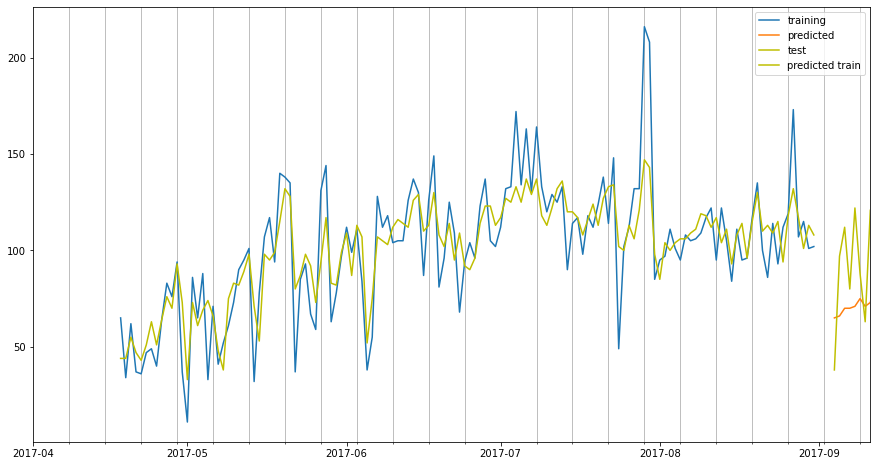

In [235]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

#### 6.4.2 XGBoost grid search

In [288]:
grid = {
        'learning_rate': np.arange(0.1,1.0,0.1),
        'min_child_weight': [1, 3, 5],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.7, 0.75, 0.8,0.85,0.9],
        'colsample_bytree': np.arange(0.1,1,0.1),
        'max_depth': range(3,10),
        'n_estimators': range(400,1400,200),
        'reg_alpha': [200], 
        'reg_lambda':[200], 
         'nthread': [4], 
        }
 

pprint(grid)

{'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'gamma': [0, 0.5, 1, 1.5, 2, 5],
 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'max_depth': range(3, 10),
 'min_child_weight': [1, 3, 5],
 'n_estimators': range(400, 1400, 200),
 'nthread': [4],
 'reg_alpha': [200],
 'reg_lambda': [200],
 'subsample': [0.7, 0.75, 0.8, 0.85, 0.9]}


In [277]:
xg = xgb.XGBRegressor()
xg_grid = GridSearchCV(estimator = xg, 
                               param_grid = grid, 
                             cv = 3, verbose=2, n_jobs = -1)
xg_random = RandomizedSearchCV(estimator = xg, 
                               param_distributions = grid, 
                               n_iter = 100, cv = 3, verbose=10, random_state=23, n_jobs = -1)

In [266]:
for learning_rate in grid['learning_rate']:
    xg=  xgb.XGBRegressor( learning_rate =learning_rate, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(learning_rate, MAPE(test_Y, pred_Y))

0.1 0.22319367179082297
0.2 0.2184175903508727
0.30000000000000004 0.21370628033649908
0.4 0.21202173620778395
0.5 0.20827798921529947
0.6 0.20253646920754442
0.7000000000000001 0.2015790234724395
0.8 0.2108696124574292
0.9 0.2076076030383899


In [270]:
#We choose learning_rate= 0.6

In [269]:
for colsample_bytree in grid['colsample_bytree']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=1000, max_depth=3,
    min_child_weight=3, gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=colsample_bytree,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(colsample_bytree, MAPE(test_Y, pred_Y))

0.1 0.2076076030383899
0.2 0.3098866733170432
0.30000000000000004 0.29219039233294913
0.4 0.328333840696256
0.5 0.3423936595006451
0.6 0.3254262297274245
0.7000000000000001 0.3524807796567489
0.8 0.3561408154399788
0.9 0.3507162774502832


In [ ]:
#choose colsample_bytree of 0.1

In [274]:
for n_estimators in grid['n_estimators']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=n_estimators, max_depth=3,
    min_child_weight=3, gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(n_estimators, MAPE(test_Y, pred_Y))

400 0.2010224351603697
600 0.20251117296760568
800 0.20334344922332814
1000 0.20253646920754442
1200 0.20316672465629673


In [ ]:
#we choose n_estimators as 400

In [279]:
for min_child_weight in grid['min_child_weight']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=400, max_depth=3,
    min_child_weight=min_child_weight, gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(min_child_weight, MAPE(test_Y, pred_Y))

1 0.20563958978812502
3 0.2010224351603697
5 0.2013385118183429


In [280]:
#Leave min_child_weight at 3 

In [284]:
for gamma in grid['gamma']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=400, max_depth=3,
    min_child_weight=3, gamma=gamma, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(gamma, MAPE(test_Y, pred_Y))

0 0.2010224351603697
0.5 0.2016951163886065
1 0.20239107115154695
1.5 0.20239107115154695
2 0.20239107115154695
5 0.20137075951570604


In [280]:
#Leave gamma at 0

In [285]:
for max_depth in grid['max_depth']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=400, max_depth=max_depth,
    min_child_weight=3, gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(max_depth, MAPE(test_Y, pred_Y))

3 0.2010224351603697
4 0.2010224351603697
5 0.2010224351603697
6 0.2010224351603697
7 0.2010224351603697
8 0.2010224351603697
9 0.2010224351603697


In [286]:
#Leave maxdepth at 3 - no difference observed

In [289]:
for subsample in grid['subsample']:
    xg=  xgb.XGBRegressor( learning_rate =0.6, n_estimators=400, max_depth=3,
    min_child_weight=3, gamma=0, subsample=subsample, reg_alpha=200, reg_lambda=200, colsample_bytree=0.1,nthread=4)
    xg.fit(train_X, train_Y)
    y_pred = xg.predict(test_X)
    pred_Y = pd.Series(y_pred, index= test_Y.index).apply(round)
    print(subsample, MAPE(test_Y, pred_Y))

0.7 0.2040477191833359
0.75 0.20802669988337302
0.8 0.2010224351603697
0.85 0.2039703707886694
0.9 0.20266238176721868


#### 7.1 Linear booster

In [297]:
train_X.columns

Index([    ('t1', 'rides_count_members'), ('t1', 'rides_count_non_members'),
            ('t1', 'total_duration_all'),     ('t2', 'rides_count_members'),
       ('t2', 'rides_count_non_members'),      ('t2', 'total_duration_all'),
           ('t3', 'rides_count_members'), ('t3', 'rides_count_non_members'),
            ('t3', 'total_duration_all'),         ('today', 'year_minus_0'),
               ('today', 'year_minus_1'),                            'Tues',
                                   'Wed',                           'Thurs',
                                   'Fri',                             'Sat',
                                   'Sun'],
      dtype='object')

In [295]:
train_X.columns == test_X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

In [327]:
for lamb in np.round(np.arange(0,0.5, 0.05),2):
    for alpha in np.round(np.arange(0,0.5,0.05),2):
        xg=  xgb.XGBRegressor( reg_lambda= lamb, alpha = alpha,
                     booster='gblinear', verbosity=0)
        xg.fit(train_X, train_Y)
        y_pred = xg.predict(test_X)
        pred_Y = pd.Series(y_pred, index= test_Y.index)
        print(lamb, alpha, MAPE(test_Y, pred_Y))

0.0 0.0 0.19284633900529086
0.0 0.05 0.21002622084910463
0.0 0.1 0.24951266016849113
0.0 0.15 0.2767875424962783
0.0 0.2 0.2862746735259411
0.0 0.25 0.2869139014929735
0.0 0.3 0.28716141329211886
0.0 0.35 0.33095754387654286
0.0 0.4 0.2922957371107724
0.0 0.45 0.3178424536093826
0.05 0.0 0.2961115720915536
0.05 0.05 0.27558563265489894
0.05 0.1 0.29896716387102135
0.05 0.15 0.3008555509578153
0.05 0.2 0.2882475293313219
0.05 0.25 0.3052202667568177
0.05 0.3 0.29747047997665743
0.05 0.35 0.2778249557750238
0.05 0.4 0.3047960338310671
0.05 0.45 0.28631640309786915
0.1 0.0 0.29478834051815456
0.1 0.05 0.2978903193487999
0.1 0.1 0.2927101125926422
0.1 0.15 0.2803453972681334
0.1 0.2 0.2883169987195241
0.1 0.25 0.29029280560071985
0.1 0.3 0.292347109748253
0.1 0.35 0.2625466688897371
0.1 0.4 0.288005168504472
0.1 0.45 0.2944518449673731
0.15 0.0 0.28386517985729615
0.15 0.05 0.2841087650672183
0.15 0.1 0.24583134566275025
0.15 0.15 0.28451999632529995
0.15 0.2 0.2871729425645172
0.15 0.25 0

In [307]:
#We choose lambda = alpha = 0 as the solution

In [438]:
xglinear=  xgb.XGBRegressor( reg_lambda= 0, alpha = 0,
                     booster='gblinear', verbosity =0)
xglinear.fit(train_X, train_Y)

XGBRegressor(alpha=0, base_score=0.5, booster='gblinear',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, gamma=None, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=8, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=0)

In [334]:
#For some reason this is not working:
#xg_random.fit(train_X,train_Y)

In [335]:
y_pred = xg.predict(test_X)
pred_Y = pd.Series(y_pred, index= test_Y.index)

y_pred = xg.predict(train_X)
pred_train_Y = pd.Series(y_pred, index= train_Y.index)


In [336]:
MAPE(test_Y,pred_Y)

0.19293962917464885

In [337]:
RMSE(test_Y,pred_Y)

26.648621834683603

In [338]:
MAPE_analysis ['xgb_linear'] = Out[336]
RMSE_analysis ['xgb_linear'] = Out[337]

**performs worst than the regression and random forest**

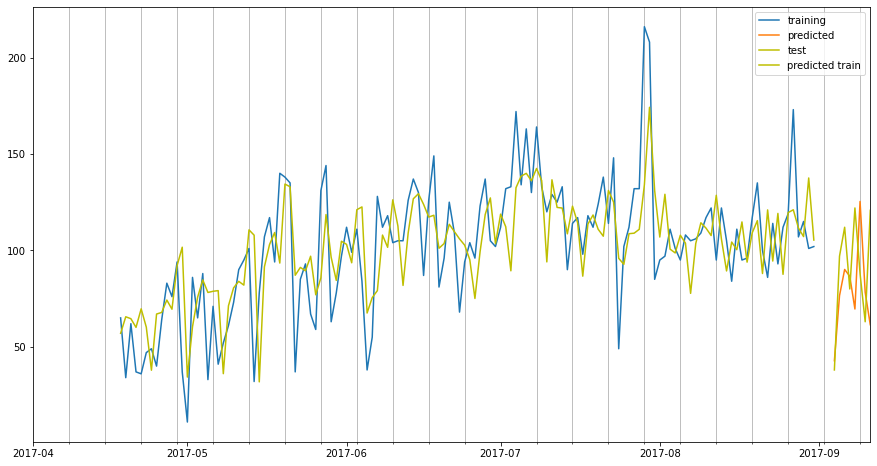

In [339]:
fig, ax = plt.subplots(figsize=(15,8))


plt.plot(train_Y, label='training')
plt.plot(pred_Y, label='predicted')
plt.plot(test_Y,label = 'test', c= 'y')
plt.plot(pred_train_Y,label = 'predicted train', c= 'y')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor')

ax.set_xlim(( dt.date(2017, 4, 1), dt.date(2017, 9, 11)))

plt.show()

## 7. Prediction and Conclusion

### 7.1 Choosing the model 

Based on all the models tested, the xgblinear model has a MAPE of ~19% and has the best performance. It is significantly better than the XGBOost tree models and would be choosing that model. 

### 7.2 Extracting the Station specific demand

In [490]:
test_demand['start_date'] = pd.to_datetime(test_demand['start_date'])

In [347]:
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

In [346]:
stations_df.xs(6184)

name         Métro Mont-Royal (Rivard / du Mont-Royal)
latitude                                     45.524673
longitude                                    -73.58255
Year_2014                                       2014.0
Year_2015                                       2015.0
Year_2016                                       2016.0
Year_2017                                       2017.0
category                                 Fully Matched
cluster                                             38
Name: 6184, dtype: object

In [348]:
stations_df.xs(6015)

name         Berri / de Maisonneuve
latitude                  45.515299
longitude                -73.561273
Year_2014                    2014.0
Year_2015                    2015.0
Year_2016                    2016.0
Year_2017                    2017.0
category              Fully Matched
cluster                          44
Name: 6015, dtype: object

In [353]:
prio_cluster_data = df[(df.start_cluster==38) & (df.end_cluster==44)]

In [355]:
prio_cluster_data.start_station_code.nunique()

18

In [356]:
prio_cluster_data.start_station_code.value_counts()

6184    7889
6248    5199
6213    5054
6220    4674
6181    4166
6221    3856
6217    3292
6903    3208
6187    3047
6183    2935
6223    2772
6216    2663
6307    2498
6201    2394
6229    1692
6222    1664
6182    1655
6212    1488
Name: start_station_code, dtype: int64

In [358]:
prio_cluster_data.end_station_code.nunique()

17

In [359]:
prio_cluster_data.end_station_code.value_counts()

6012    11542
6015    11050
6014     4671
6009     4569
6020     3787
6104     2960
6901     2912
6008     2833
6018     2607
6729     2482
6013     2440
6112     2218
6180     2095
6007     2034
6171     1583
7074      333
7001       30
Name: end_station_code, dtype: int64

In [370]:
total_start_rides_by_month = prio_cluster_data.reset_index(level=1, drop =True).reset_index().groupby(by='index').size()

In [371]:
mountroyal_start_rides_by_month= prio_cluster_data[prio_cluster_data.start_station_code==6184].reset_index(level=1, drop =True).reset_index().groupby(by='index').size()

In [440]:
Berri_start_rides_by_month= prio_cluster_data[prio_cluster_data.end_station_code==6015].\
                            reset_index(level=1, drop =True).reset_index().groupby(by='index').size()

In [441]:
point_to_point_rides_by_month = prio_cluster_data[(prio_cluster_data.start_station_code==6184) 
                                                  & (prio_cluster_data.end_station_code==6015)].\
                                 reset_index(level=1, drop =True).reset_index().groupby(by='index').size()

In [443]:
month_rides = pd.DataFrame([total_start_rides_by_month, mountroyal_start_rides_by_month, Berri_start_rides_by_month,point_to_point_rides_by_month]).T

In [446]:
month_rides.columns = ["total_rides", "start_rides_6184", "end_rides_6015", "start_end_rides"]

In [447]:
month_rides.dtypes

total_rides         int64
start_rides_6184    int64
end_rides_6015      int64
start_end_rides     int64
dtype: object

In [449]:
month_rides

total_rides  start_rides_6184  end_rides_6015  start_end_rides
index                                                                  
2014-04          463                91              86               30
2014-05         1962               333             298               70
2014-06         2263               362             292               65
2014-07         2373               438             398              123
2014-08         2088               399             340               92
2014-09         1913               344             302               84
2014-10         1428               248             240               78
2014-11          479                63              82               18
2015-04          589                95             112               19
2015-05         2183               351             341               87
2015-06         2420               373             336               77
2015-07         2848               404             499               99
2015-08         2699               353             488               85
2015-09         2195               309             394               74
2015-10         1587               191             295               53
2015-11          627                77             109               20
2016-04          884               125             127               29
2016-05         2427               302             434               73
2016-06         2968               385             458               82
2016-07         3207               368             595               93
2016-08         2958               325             532               91
2016-09         2898               272             571               85
2016-10         1989               215             405               66
2016-11          819                77             172               31
2017-04          814                80             153               13
2017-05         2562               256             463               50
2017-06         3166               314             629               71
2017-07         3989               434            1055              163
2017-08         3348               305             844              109

In [453]:
  month_rides[['start_ratio', 'end_ratio', 'start_end_ratio']] = month_rides[['start_rides_6184','end_rides_6015','start_end_rides']].\
                                        div(month_rides['total_rides'],axis=0)

In [463]:
month_rides['independent_product'] = month_rides['start_ratio']*month_rides['end_ratio']

In [456]:
month_rides.index = pd.to_datetime(month_rides.index)

In [461]:
month_rides.columns

Index(['total_rides', 'start_rides_6184', 'end_rides_6015', 'start_end_rides',
       'start_ratio', 'end_ratio', 'start_end_ratio', 'independent_proudct'],
      dtype='object')

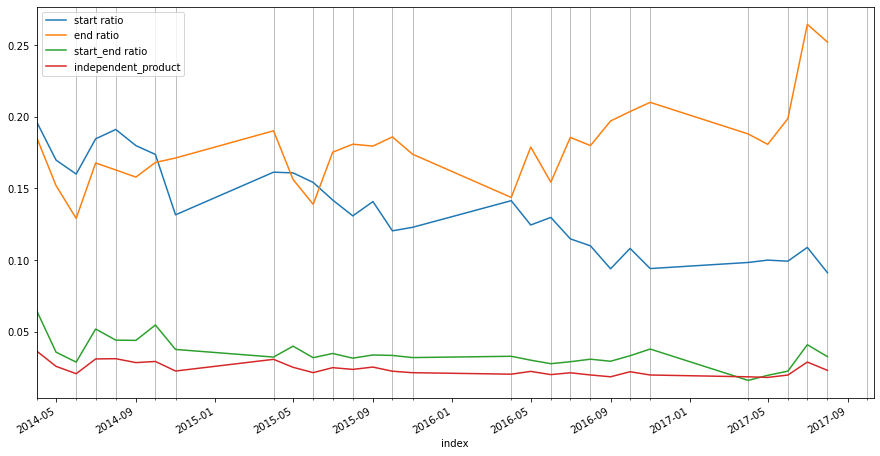

In [464]:
minor_ticks = [dt.date(year,month,1) for year in range(2014,2018) for month in range(4,12)]

fig, ax = plt.subplots(figsize=(15,8))


month_rides.plot(y='start_ratio', label='start ratio', ax= ax)
month_rides.plot(y='end_ratio', label='end ratio', ax = ax)
month_rides.plot(y='start_end_ratio', label='start_end ratio', ax= ax)
month_rides.plot(y='independent_product', label='independent_product', ax = ax)

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which ='minor')

ax.set_xlim(( dt.date(2014, 4, 1), dt.date(2017, 10, 11)))

plt.show()

We observe that the start ratio has come down in 2017 as expected because of the new stations that were added in the area. 

Equally, we have observed that the end ratio has gone up related to the closures of stations in 2017. 

As a matter of simplicity, we will take the average of the last 3 months to predict the ratio for September

In [465]:
month_rides[['start_ratio','end_ratio', 'start_end_ratio', 'independent_product']].iloc[-3:].mean()

start_ratio            0.099692
end_ratio              0.238414
start_end_ratio        0.031948
independent_product    0.023815
dtype: float64

In [466]:
month_rides[['start_ratio','end_ratio', 'start_end_ratio', 'independent_product']].iloc[-4:].mean()

start_ratio            0.099750
end_ratio              0.223990
start_end_ratio        0.028840
independent_product    0.022376
dtype: float64

In [467]:
month_rides[['start_ratio','end_ratio', 'start_end_ratio', 'independent_product']].iloc[-5:].mean()

start_ratio            0.099456
end_ratio              0.216784
start_end_ratio        0.026266
independent_product    0.021595
dtype: float64

In [474]:
month_rides[['start_ratio','end_ratio', 'start_end_ratio', 'independent_product']].iloc[-3:].std()

start_ratio            0.008861
end_ratio              0.034969
start_end_ratio        0.009233
independent_product    0.004595
dtype: float64

In [437]:
#The start ratio has been pretty consistent for 2017, and it has somewhat stabilizied the starting demand at Mount Royal. 

#Equally, the end-ratio is only off by 1-2% of the total, which we can use as a confidence interval 

In [498]:
cluster_ratio = 0.031948
cluster_ratio_std = 0.009233

In [499]:
final_demands = xglinear.predict(test_X)*cluster_ratio
final_demands = pd.Series(final_demands, index= test_Y.index)

In [500]:
final_demands_max = xglinear.predict(test_X) * (cluster_ratio + cluster_ratio_std)
final_demands_max = pd.Series(final_demands_max, index= test_Y.index)

In [501]:
final_demands_min = xglinear.predict(test_X) * (cluster_ratio - cluster_ratio_std)
final_demands_min = pd.Series(final_demands_min, index= test_Y.index)

In [502]:
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

In [503]:
test_demand['start_date'] = pd.to_datetime(test_demand['start_date'])

In [504]:
final_demand_actual = test_demand[(test_demand.start_station_code==6184) & (test_demand.end_station_code == 6015)].groupby(by=test_demand.start_date.dt.date)['duration_sec'].size()

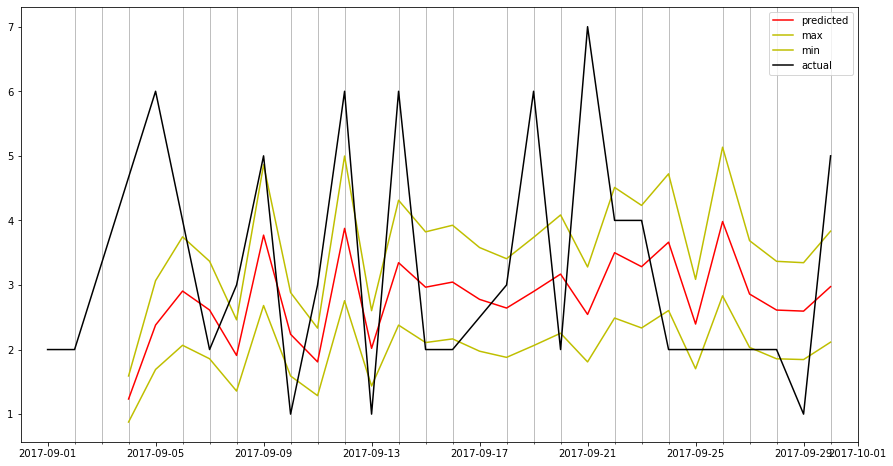

In [505]:
minor_ticks = [dt.date(2017,9,day) for day in range(1,31)]

fig, ax = plt.subplots(figsize=(15,8))


plt.plot(final_demands, label='predicted', c='r')
plt.plot(final_demands_max, label='max', c='y')
plt.plot(final_demands_min, label='min', c='y')
plt.plot(final_demand_actual, label='actual', c='k')

plt.legend(loc='best')
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which ='minor')

ax.set_xlim(( dt.date(2017, 8, 31), dt.date(2017, 10, 1)))

plt.show()

### 7.3 Discussion on analysis

The XGBlinear model at a cluster level, appears to have a 20% MAPE, which is quite good, as far as prediction models go. Further, it does appear to capture the weekly cyclicity. 

It goes to show that the Auto-Regressive and MOving average aspect of the time series, which is quite eloquently cpatured in both the linear regression and the XGBlinear model is the best model for this situation. 


Having tested a wide variety of models, it seems that the machine learning models did not perform as well as they could have. This appears to be mainly because of poor hyper parameter optimization. There was also a technical issue in resolving the XGBoost model. 

Likewise, the time series, which is often much more effective in these types of scenarios did not perform well. This may be because we require some kind of smoothing between the daily buckets. Some kind of expoential smoothing (to capture the monthly seasonality aspect) and annual ratios (to capture the yoy growth of Bixi bike) may be the correct path forward, here. 

There may also be a case for greater feature selection (e.g., member vs. non-member analysis) + PCA/ t-sne to filter the features more efficiently. 

A "good answer" would be around 12% MAPE or less, based on personal experience. Herein, our model is not satisfactory in that sense and could need more work. 

Interesting problem, overall.